In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()

%output size=150
dims = SimpleNamespace(E_t=holoviews.Dimension(r'$E/t$'),
                       mu_t=holoviews.Dimension(r'$\mu/t$'),
                       lambda_=holoviews.Dimension(r'$\lambda$'),
                       x=holoviews.Dimension(r'$x$'),
                       k=holoviews.Dimension(r'$k$'),
                       amplitude=holoviews.Dimension(r'$|u|^2 + |v|^2$'))

holoviews.core.dimension.title_format = ''

def kitaev_chain(L=None, periodic=False):
    lat = kwant.lattice.chain()

    if L is None:
        sys = kwant.Builder(kwant.TranslationalSymmetry((-1,)))
        L = 1
    else:
        sys = kwant.Builder()

    # transformation to antisymmetric basis
    U = np.array([[1.0, 1.0], [1.j, -1.j]]) / np.sqrt(2)

    def onsite(onsite, p): 
        return - p.mu * U.dot(pauli.sz.dot(U.T.conj()))
    
    for x in range(L):
        sys[lat(x)] = onsite

    def hop(site1, site2, p):
        return U.dot((-p.t * pauli.sz - 1j * p.delta * pauli.sy).dot(U.T.conj()))
    
    sys[kwant.HoppingKind((1,), lat)] = hop

    if periodic:
        def last_hop(site1, site2, p):
            return hop(site1, site2, p) * (1 - 2 * p.lambda_)
        
        sys[lat(0), lat(L - 1)] = last_hop
    return sys


def bandstructure(mu, delta=1, t=1, Dirac_cone="Hide", show_pf=False):
    sys = kitaev_chain(None)
    p = SimpleNamespace(t=t, delta=delta, mu=mu)
    plot = holoviews.Overlay([spectrum(sys, p, ydim="$E/T$", xdim='$k$')][-4:4])
    h_1 = h_k(sys, p, 0)
    h_2 = h_k(sys, p, np.pi)
    pfaffians = [find_pfaffian(h_1), find_pfaffian(h_2)]
    
    if show_pf:
        signs = [('>' if pf > 0 else '<') for pf in pfaffians]
        title = "$\mu = {mu} t$, Pf$(iH_{{k=0}}) {sign1} 0$, Pf$(iH_{{k=\pi}}) {sign2} 0$"
        title = title.format(mu=mu, sign1=signs[0], sign2=signs[1])
        plot *= holoviews.VLine(0) * holoviews.VLine(-np.pi)
    else:
        if pfaffians[0] * pfaffians[1] < 0:
            title = "$\mu = {mu} t$, topological ".format(mu=mu)
        else:
            title = "$\mu = {mu} t$, trivial ".format(mu=mu)
        
    if Dirac_cone == "Show":
        ks = np.linspace(-np.pi, np.pi)
        ec = np.sqrt((mu + 2 * t)**2 + 4.0 * (delta * ks)**2)
        plot *= holoviews.Path((ks, ec), kdims=[dims.k, dims.E_t])(style={'linestyle':'--', 'color':'r'})
        plot *= holoviews.Path((ks, -ec), kdims=[dims.k, dims.E_t])(style={'linestyle':'--', 'color':'r'})
    return plot.relabel(title)

def find_pfaffian(H):
    return np.sign(np.real(pf.pfaffian(1j*H)))

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

## We present three approaches to bulk-edge correspondence: Strong coupling, Dirac, and topological-invariant.

* Majorana modes in strong coupling: chain of decoupled quantum dots
* Topological quantum phase transitions, Dirac models and domain-wall Majorana modes
* Topological invariants and the bulk-edge correspondence: fermion parity pumping

**NO CONTENT ABOVE THIS LINE IS VISIBLE IN EDX**

# Kitaev chain and bulk-edge correspondence

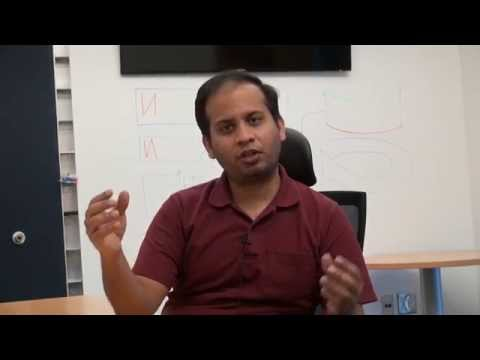

In [2]:
MoocVideo("U84MzZm9Gbo", src_location='1.2-intro')

# Unpaired Majorana modes in one-dimensional systems

## Fermion operators and Majorana operators

Let's start from the creation and annihilation operators $c^\dagger$ and $c$ of a fermionic mode. These operators satisfy the anticommutation relation $c^\dagger c + cc^\dagger = 1$ and, furthermore, square to zero, $c^2=0$ and $(c^\dagger)^2=0$. They connect two states $\left|0\right\rangle$ and $\left|1\right\rangle$ which correspond to the 'vacuum' state with no particle and the 'excited' state with one particle, according to the following rules $c \left|0\right\rangle = 0$, $c^\dagger\left|0\right\rangle=\left|1\right\rangle$ and $c^\dagger \left|1\right\rangle = 0$.

When you have a pair of $c$ and $c^\dagger$ operators, you can write them down in the following way

$$ c^\dagger = \tfrac{1}{2}(\gamma_1+i\gamma_2),\;\; c = \tfrac{1}{2}(\gamma_1-i\gamma_2).$$

The operators $\gamma_1$ and $\gamma_2$ are known as Majorana operators. By inverting the transformation above, you can see that $\gamma_1=\gamma_1^\dagger$ and $\gamma_2=\gamma_2^\dagger$. Because of this property, we cannot think of a single Majorana mode as being 'empty' or 'filled', as we can do for a normal fermionic mode. This makes Majorana modes special.

You can also check that to maintain all the properties of $c$ and $c^\dagger$, the operators $\gamma_1$ and $\gamma_2$ must satisfy the following relations:

$$\gamma_1\gamma_2 + \gamma_2\gamma_1 = 0\;,\;\gamma_1^2=1\;,\;\gamma_2^2=1\;.$$

You can see that Majorana modes are similar to normal fermions in the sense that they have operators which all anticommute with each other. Using Majorana modes instead of normal fermionic modes is very similar to writing down two real numbers in place of a complex number. Indeed, every fermion operator can always be expressed in terms of a pair of Majorana operators. This also means that Majorana modes always come in even numbers.

The two Majorana operators $\gamma_1, \gamma_2$ still act on the same states $\left|0\right\rangle$ and $\left|1\right\rangle$.
If these two states have an energy difference $\epsilon$, this corresponds to a Hamiltonian $H=\epsilon c^\dagger c$.
We can also express this Hamiltonian in terms of Majoranas as $H=\tfrac{1}{2}\,\epsilon\,(1 - i\gamma_1\gamma_2)$.

But is it possible to have a single isolated Majorana mode, one that is not close to its partner?
The naive answer is 'no': condensed matter systems are made out of electrons, and these always correspond to pairs of Majoranas.
However, it turns out that by engineering the Hamiltonian in a special way it actually is possible to separate two Majoranas.

## Unpaired Majorana modes in a model of dominoes

Let's see how creating isolated Majoranas can be done. Let us consider a chain of $N$ sites, where each site can host a fermion with creation operator $c^\dagger_n$. Equivalently, each site hosts two Majorana modes $\gamma_{2n-1}$ and $\gamma_{2n}$. This situation is illustrated below for $N=4$, where each site is represented by a domino tile.

![](figures/majorana_dominoes.svg)

What happens if we pair the Majoranas? This means that the energy cost for each fermion to be occupied is $\mu$, and the Hamiltonian becomes

$$H=(i/2)\,\mu\, \sum_{n=1}^{N} \gamma_{2n-1}\gamma_{2n}.$$

This is how the pairing looks:

![](figures/trivial_dominoes.svg)

All the excitations in this system have an energy $\pm|\mu|/2$, and the chain has a gapped bulk and no zero energy edge states.

Of course this didn't help us to achieve our aim, so let's pair the Majoranas differently.
We want only one Majorana to remain at an edge, so let's pair up the Majoranas from *adjacent* sites, leaving the first one and the last one without a neighboring partner:

![](figures/topological_dominoes.svg)

To every pair formed in this way, we assign an energy difference $2t$ between the empty and filled state, hence arriving at the Hamiltonian

$$H=it \sum_{n=1}^{N-1} \gamma_{2n}\gamma_{2n+1}.$$

You can see that the two end Majorana modes $\gamma_1$ and $\gamma_{2N}$ do not appear in $H$ at all.
Hence our chain has two zero-energy states, localized at its ends.
All the states which are not at the ends of the chain have an energy of $\pm |t|$, independently on the length of the chain. Hence, we have a one-dimensional system with a gapped bulk and zero energy states at the edges.

## The Kitaev chain model

Let us now try to write the Hamiltonian $H$, which we have so far written in terms of Majoranas, in terms of regular fermions by substituting $\gamma_{2n-1}=(c_n^\dagger+c_n)$ and $\gamma_{2n}=-i(c_n^\dagger-c_n)$. We find that both pairings sketched above are extreme limits of one tight-binding Hamiltonian for a one-dimensional superconducting wire:

$$H=-\mu\sum_n c_n^\dagger c_n-t\sum_n (c_{n+1}^\dagger c_n+\textrm{h.c.}) + \Delta\sum_n (c_n c_{n+1}+\textrm{h.c.})\,.$$

It has three real parameters: the onsite energy $\mu$, the hopping $t$ between different sites, and the superconducting pairing $\Delta$. Note that the $\Delta$ terms create or annihilate pairs of particles at neighboring sites.

Starting from this Hamiltonian, the unpaired Majorana regime is the special point $\Delta=t$ and $\mu=0$, while the completely trivial regime of isolated fermions is $\Delta=t=0$ and $\mu\neq 0$.

As we learned just before, it is useful to write down the above superconducting Hamiltonian in the Bogoliubov-de Gennes formalism $H = \tfrac{1}{2} C^\dagger H_\textrm{BdG} C$, with $C$ a column vector containing all creation and annihilation operators, $C=(c_1, \dots, c_N, c_1^\dagger, \dots, c^\dagger_N)^T$. The $2N\times 2N$ matrix $H_\textrm{BdG}$ can be written in a compact way by using Pauli matrices $\tau$ in particle and hole space, and denoting with $\left|n\right\rangle$ a column basis vector $(0,\dots,1,0,\dots)^T$ corresponding to the $n$-th site of the chain. In this way, we have for instance that $C^\dagger\,\tau_z\,\left|n\right\rangle\left\langle n\right|\,C = 2c_n^\dagger c_n$. The Bogoliubov-de Gennes Hamiltonian is then given by

$$H_{BdG}=-\sum_n \mu \tau_z\left|n\right\rangle\left\langle n\right|-\sum_n \left[(t\tau_z+i\Delta\tau_y)\,\left|n\right\rangle\left\langle n+1 \right| + \textrm{h.c.}\right].$$

The BdG Hamiltonian acts on a set of basis states $\left|n\right\rangle\left|\tau\right\rangle$, with $\tau=\pm 1$ corresponding to electron and hole states respectively. It has particle-hole symmetry, $\mathcal{P}H_\textrm{BdG}\mathcal{P}^{-1}=-H_\textrm{BdG}$ with $\mathcal{P}=\tau_x\mathcal{K}$.

## Topological protection of edge Majorana modes

The fact that the Kitaev model can have unpaired Majorana zero modes is certainly interesting. At this point you might however object:

"Unpaired Majoranas appear because you chose one particular, and perhaps even unreachable, set of parameters! Clearly by setting $\mu=0$ you have cut the first and last Majorana mode from the rest of the chain. I bet that if you change the value of $\mu$ only slightly from zero, the zero modes will be coupled to the rest of the chain and quickly disappear. So these Majorana modes may just be an artefact appearing in this highly tuned model!"

Well, let's test if this objection is true. Let's start from the situation with unpaired Majorana modes ($\Delta=t, \mu=0$) and then increase $\mu$. Then let's plot the energy spectrum of a chain with $N=25$ sites as a function of $\mu$, and also keep track how do the two lowest energy states of our system look like, when we change $\mu$ **(move the slider)**:

:Layout
   .HoloMap.I  :HoloMap   [$\mu/t$]
      :Overlay
         .Path.I  :Path   [$\mu/t$,$E/t$]
         .VLine.I :VLine   [x,y]
   .HoloMap.II :HoloMap   [$\mu/t$]
      :Overlay
         .Path.I  :Path   [$x$,$|u|^2 + |v|^2$]
         .Path.II :Path   [$x$,$|u|^2 + |v|^2$]
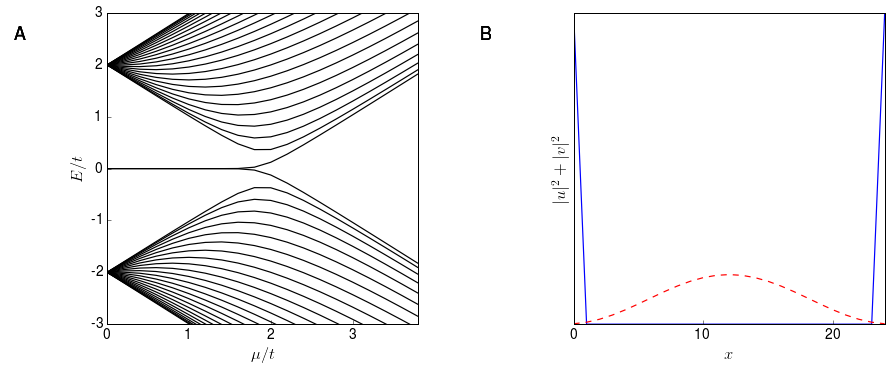
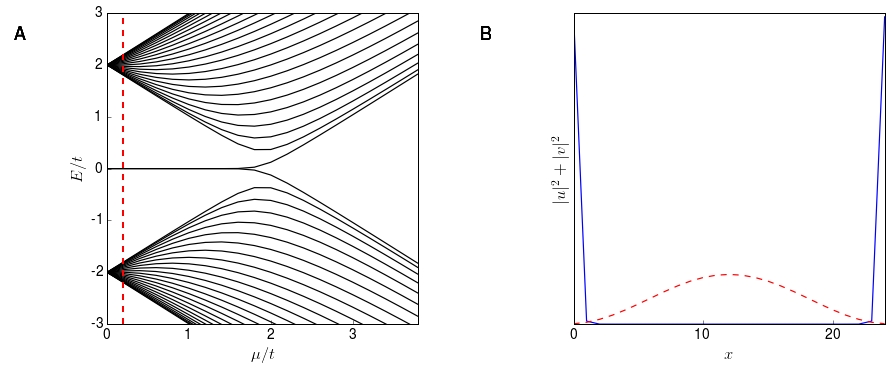
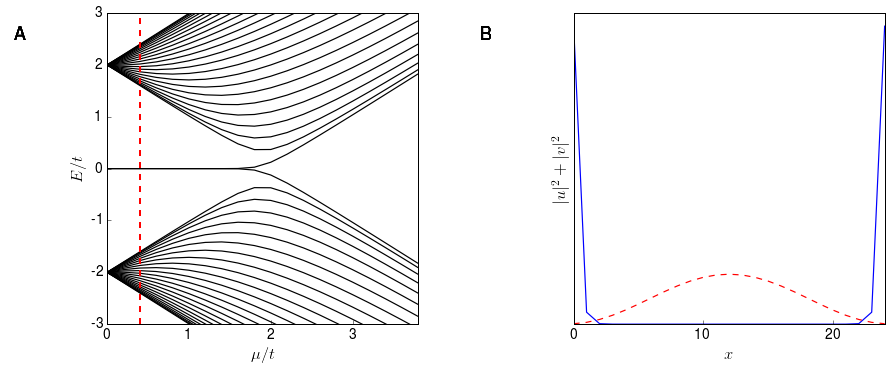
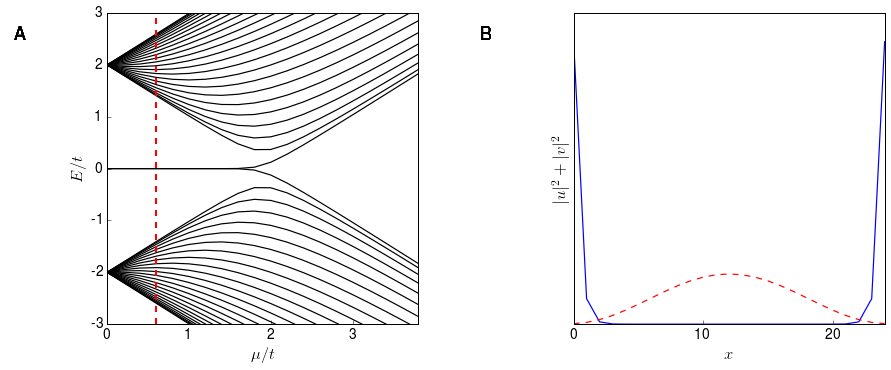
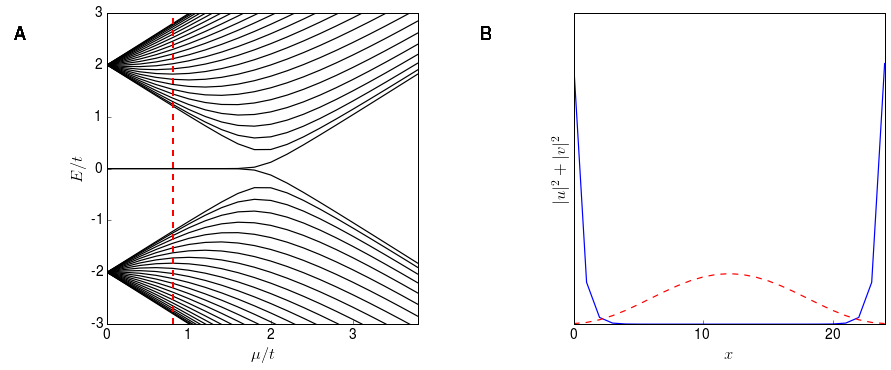
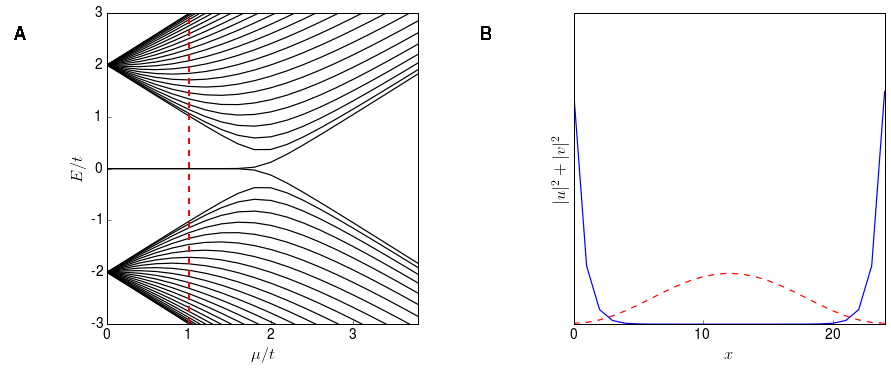
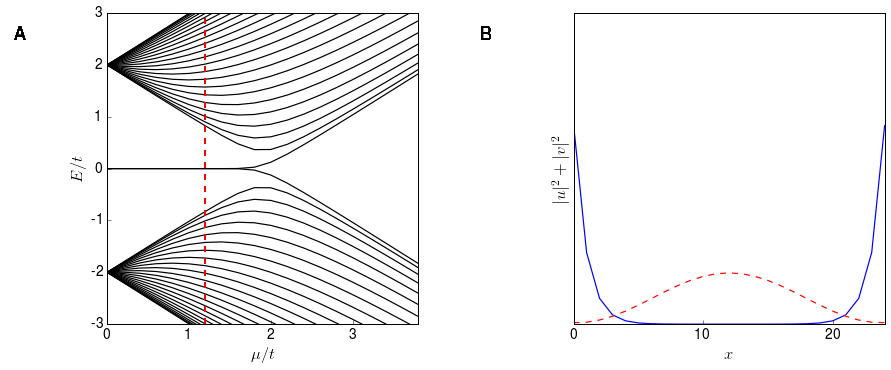
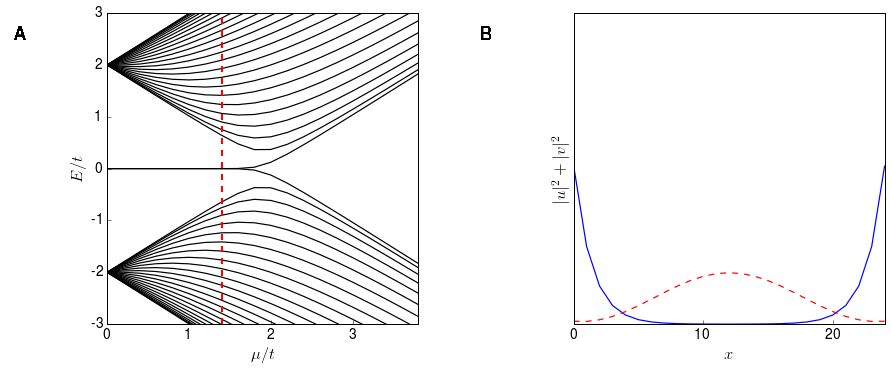
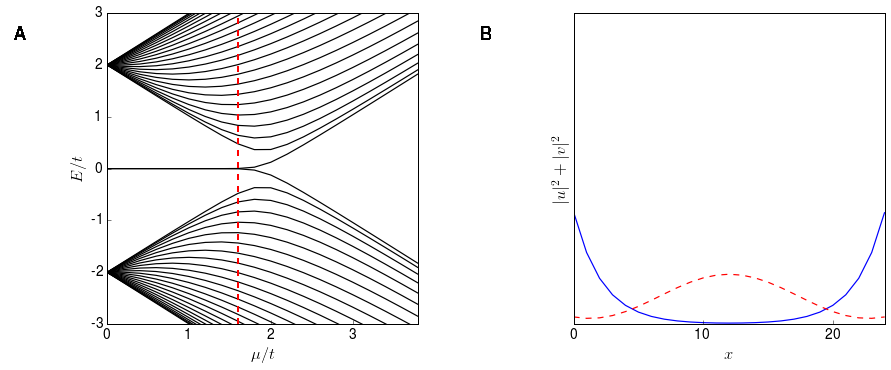
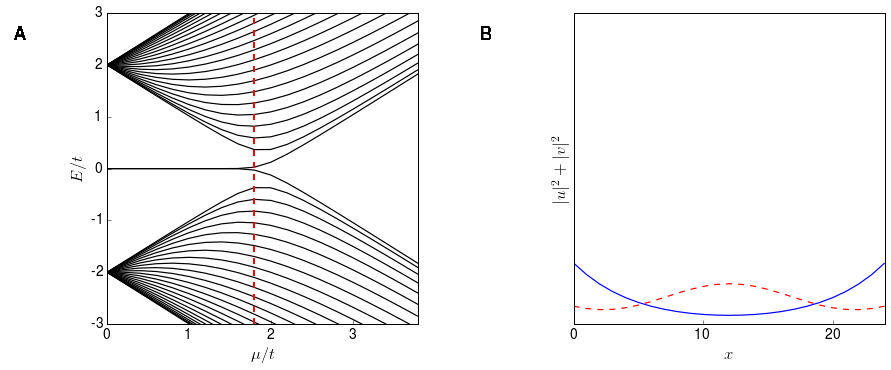
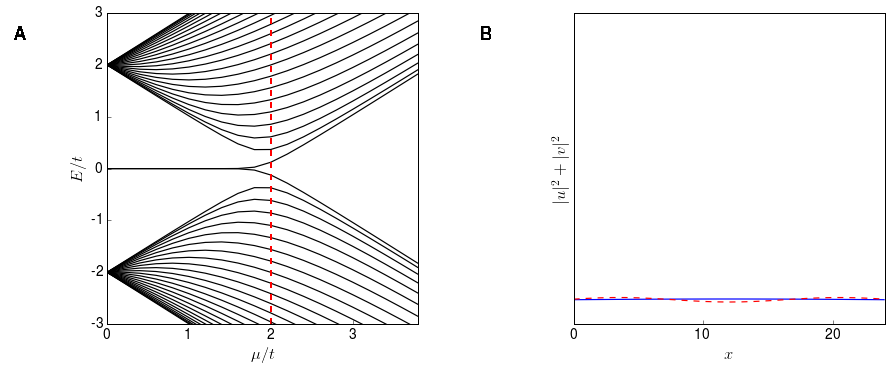
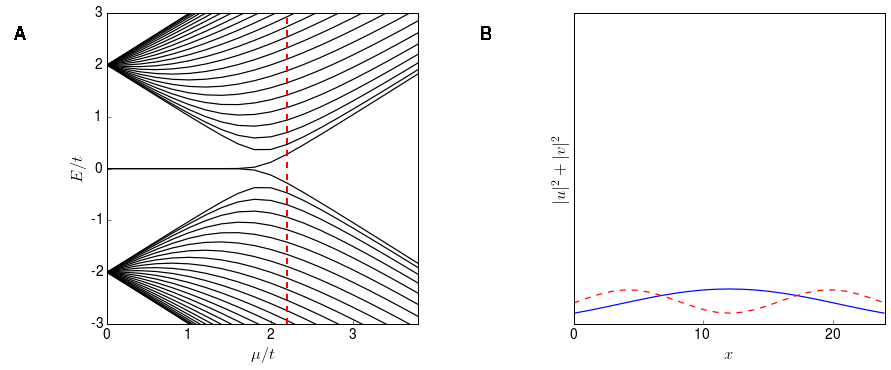
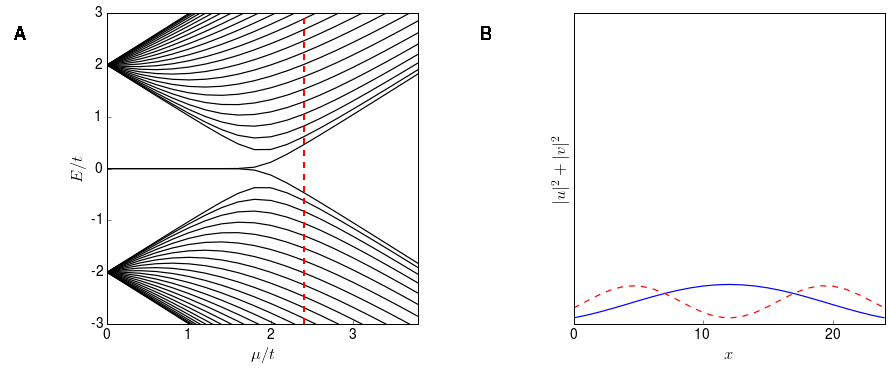
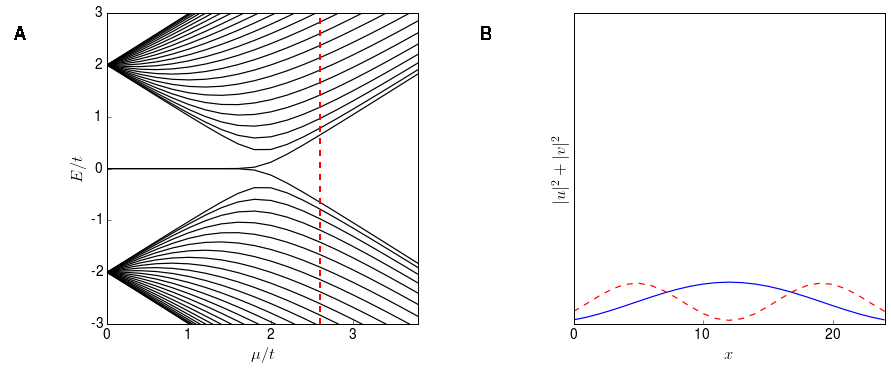
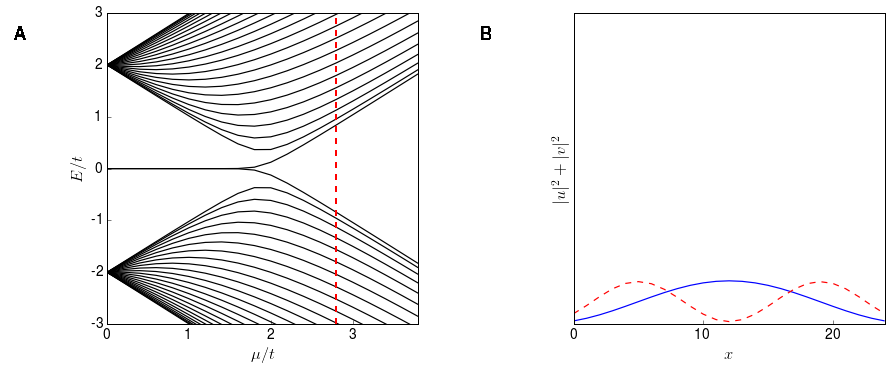
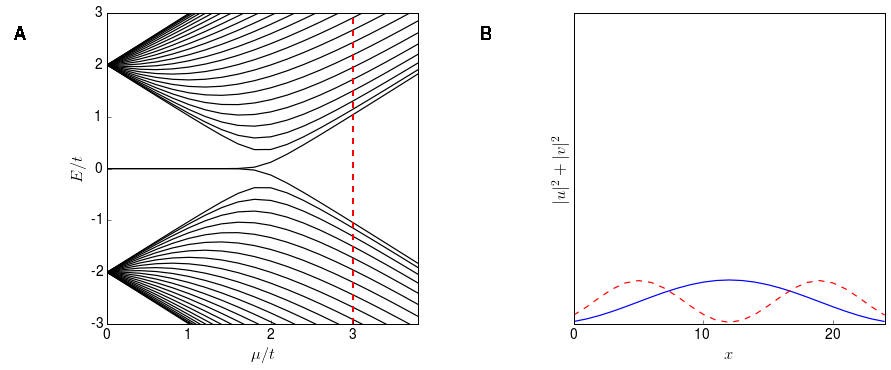
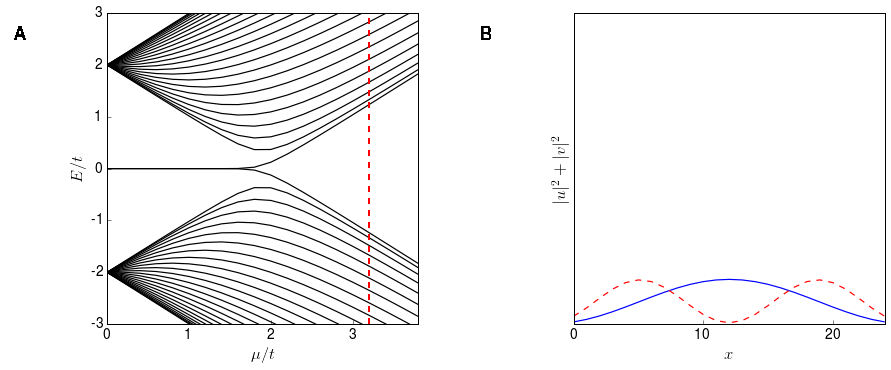
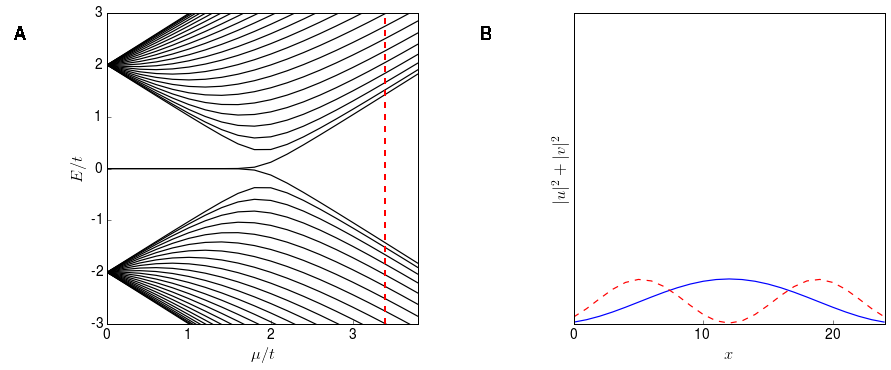
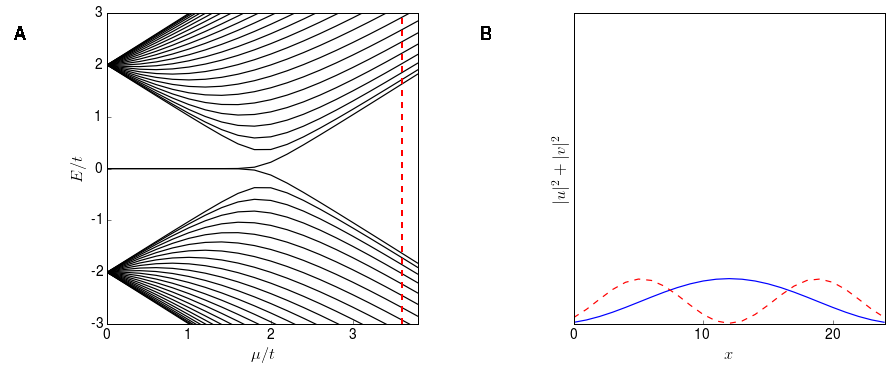
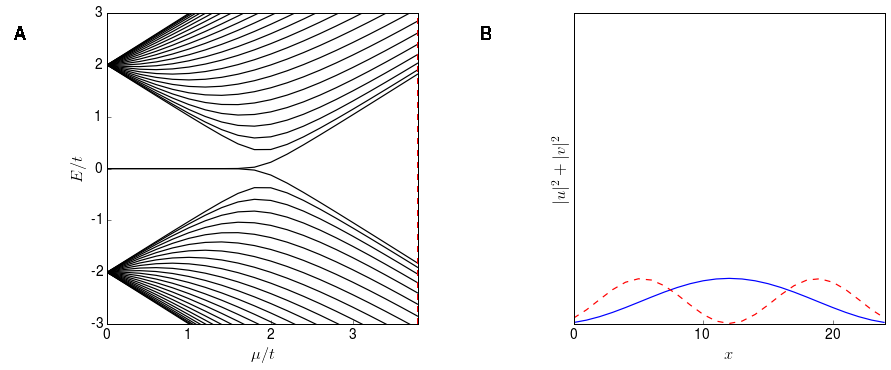

In [3]:
def plot_wf(sys, wf1, wf2, lstyle='-', lcolor='b'):
    L = sys.graph.num_nodes
    xs = np.array([sys.sites[i].pos[0] for i in range(sys.graph.num_nodes)])
    indx = np.argsort(xs)
    wf_sq = np.linalg.norm(wf1.reshape(-1, 2), axis=1)**2 + np.linalg.norm(wf2.reshape(-1, 2), axis=1)**2
    plot = holoviews.Path((xs[indx], wf_sq[indx]), kdims=[dims.x, dims.amplitude])
    return plot(style={'linestyle':lstyle, 'color':lcolor}, plot={'yticks':0, 'xticks':list(range(0, L, 10))})

def plot_pwave(L, t, delta, mu):
    # At mu=0 the first exited state is not well defined due to the massive degeneracy.
    # That is why we add a small offset to mu.
    sys = kitaev_chain(L).finalized()
    p = SimpleNamespace(t=t, delta=delta, mu=mu+1e-4)
    ham = sys.hamiltonian_submatrix(args=[p])
    ev, evec = np.linalg.eigh(ham)
    return (plot_wf(sys, evec[:, L], evec[:, L-1]) *
            plot_wf(sys, evec[:, L+1] , evec[:, L-2], lstyle='--', lcolor='r'))

sys = kitaev_chain(L=25)
mus = np.arange(0, 4, 0.2)
p = SimpleNamespace(t=1, delta=1, mu=mus)

(spectrum(sys, p, xticks=[0, 1, 2, 3], yticks=range(-3, 4), 
          xdim=dims.mu_t, ydim=dims.E_t, ylims=(-3, 3)) * 
 holoviews.HoloMap({mu: holoviews.VLine(mu) for mu in mus}, kdims=[dims.mu_t]) +
 holoviews.HoloMap({mu: plot_pwave(25, 1.0, 1.0, mu) for mu in mus}, kdims=[dims.mu_t]))

The left panel shows the spectrum, where we see two states at zero energy that split. On the right panel the blue line is the wave function of the state corresponding to the pair of Majorana modes, while the red dashed line is the wave function of the first excited state.

As you can see, the zero energy eigenvalues corresponding to the two unpaired Majorana zero modes persist for a long time, and they only split in energy when $\mu \simeq 2t$. Another thing that we observe is that the wave function of the Majoranas stays zero in the middle of our wire.

As we increase $\mu$ (try it), the wave function of the Majoranas becomes less localized near the edges of the wire, but the coupling between two ends only appears later.

You would observe a similar behavior if you varied $\mu$ in the negative direction starting from $\mu=0$. The Majoranas persist until $\mu\simeq-2t$, where the bulk gap closes.

In fact, the Majoranas only split when the higher-energy states in the bulk, originally separated by an energy gap of $2 t$, come very close to zero energy. So our investigation shows that the Majorana modes are protected **as long as the bulk energy gap is finite**.

How can we understand this? Recall that we are dealing with a particle-hole symmetric Hamiltonian. Hence, the spectrum has to be symmetric around zero energy. When $\mu=0$, we have two zero energy levels, corresponding to the Majorana modes which are localized far away from each other and separated by a gapped medium. Trying to move these levels from zero energy individually is impossible, as it would violate particle-hole symmetry:

![](figures/level_deformation_fig.svg)

The only possibility to move the energy levels from zero is to couple the two unpaired Majorana modes to each other. However, because of the spatial separation between Majoranas and of the presence of an energy gap, this coupling is impossible. The only way to split the Majorana modes in energy is to first close the bulk energy gap, and that is exactly what happens at large values of $\mu$ (to be precise, it happens at $\mu=2t$).

So we have just learned the following:

> Isolated zero end-modes at each end in the Kitaev chain are protected by **symmetry** between positive and negative energy, and by the **absence of zero-energy excitations in the bulk of the wire**, but not by fine-tuning of the chain parameters.

As you see, our conclusion sounds a lot like what we learned about topology just before. We have come to these conclusions by studying a Kitaev chain on an open geometry with boundaries, and by focusing on the presence or absence of edge states localized at the boundaries of the chain. In the rest of the unit we will see that the presence or absence of edge states can be deduced by studying the bulk alone. In order to do this, we will now study an infinite Kitaev chain without boundaries.

In [4]:
question = ("But wait! What happens if we remove the last Majorana site of a Kitaev chain"
            " in the topological phase?")
answers = ["We get a chain with a single Majorana mode.",
           "We cannot remove a single Majorana site because electrons (pairs of Majoranas) "
           "are the only physical degrees of freedom.",
           "The Hamiltonian becomes topologically trivial.",
           "Removing a single Majorana is not allowed by particle-hole symmetry"]
explanation = "Indeed, as we explained, removing a single Majorana is like removing a single pole of a magnet. So not possible."
MoocMultipleChoiceAssessment(question, answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'answers': ['We get a chain with a single Majorana mode.', 'We cannot remove a single Majorana site because electrons (pairs of Majoranas) are the only physical degrees of freedom.', 'The Hamiltonian becomes topologically trivial.', 'Removing a single Majorana is not allowed by particle-hole symmetry'], 'display_name': 'Question', 'explanation': 'Indeed, as we explained, removing a single Majorana is like removing a single pole of a magnet. So not possible.', 'correct_answer': 1, 'max_attempts': 2, 'question': 'But wait! What happens if we remove the last Majorana site of a Kitaev chain in the topological phase?'})

# Topological phases from the bulk spectrum

## Going to momentum space

The Majoranas are edge excitations that arise from the bulk-edge correspondence. You might wonder if there is a way to deduce the existence of Majorana modes by looking at the bulk? To answer this, eliminate the boundaries from the study of the Kitaev chain. You can imagine that the last site of the chain is reconnected to the first, so that the chain is closed in a ring (a “Kitaev ring”). In the absence of boundaries, the Bogoliubov-de Gennes Hamiltonian has a translational symmetry $\left|n\right\rangle\,\to\,\left|n+1\right\rangle$, since all parameters $t, \Delta$ and $\mu$ do not depend on the chain site $n$. In the presence of translational symmetries, it is always convenient to use [Bloch's theorem](http://en.wikipedia.org/wiki/Bloch_wave#Preliminaries:_Crystal_symmetries.2C_lattice.2C_and_reciprocal_lattice) and write down the Hamiltonian in momentum space rather than in real space. In our case, a state with momentum $k$ is given by

$$ \left|k\right\rangle =(N)^{-1/2} \sum_{n=1}^{N} e^{-ikn} \left|n\right\rangle.$$

We apply periodic boundary conditions, that is $\left\langle k | n=0 \right\rangle=\left\langle k | n=N \right\rangle$. The momentum $k$ is then a conserved quantum number with allowed values $2\pi p /N$ where $p=0, 1, 2, \dots, N-1$. Values of $k$ which differ by $2\pi$ are equivalent. One can also imagine that for very large $N$, $k$ is a continuous periodic variable with values in the interval $[-\pi,\pi]$, the **Brillouin zone**. Because $k$ is a good quantum number, the Bogoliubov-de Gennes Hamiltonian in momentum space can be reduced to a $2\times 2$ matrix:

$$ H(k) \equiv \left\langle k\right| H_\textrm{BdG} \left| k \right\rangle = (-2t\cos{k}-\mu)\,\tau_z + 2\Delta \sin{k}\,\,\tau_y.$$

The full Bogoliubov-de Gennes Hamiltonian is obtained by summing all these $2\times 2$ blocks:

$$ H_\textrm{BdG} = \sum_k H(k) \left| k \right\rangle\left\langle k \right|.$$

In the limit of an infinite chain the sum becomes an integral over the Brillouin zone.

## Particle-hole symmetry in momentum space

Going to momentum space does not affect the particle-hole symmetry of the Bogoliubov-de Gennes Hamiltonian. However, one must always be careful in dealing with anti-unitary operators when making a basis transformation. The reason is that the action of the complex conjugation operator might depend on the basis. In our case, we have

$$\mathcal{P}\left|k\right\rangle\!\left|\tau\right\rangle =  \left(\sum_n\,e^{-ikn}\right)^*\,\left|n\right\rangle\,\tau_x\left|\tau\right\rangle^*=\left|-k\right\rangle\,\tau_x\left|\tau\right\rangle^*.$$

Note that the particle-hole symmetry operator changes $k$ to $-k$. Therefore, the action of $\mathcal{P}$ on the Bogoliubov-de Gennes Hamiltonian written in momentum space is the following:

$$\mathcal{P}H_\textrm{BdG}\mathcal{P}^{-1} = \sum_k \tau_xH^*(k)\tau_x \left| -k \right\rangle\left\langle -k \right|=\sum_k \tau_xH^*(-k)\tau_x \left| k \right\rangle\left\langle k \right|\,.$$

In the last equality, we have used the fact that the allowed values of $k$ always come in $(-k, k)$ pairs, plus the two symmetric points $k=0$ and $k=\pi$. Therefore, particle-hole symmetry $\mathcal{P}H_\textrm{BdG}\mathcal{P}^{-1}= -H_\textrm{BdG}$ implies that

$$H(k)=-\tau_xH^*(-k)\tau_x.$$

You can verify that it is indeed the case:

$$\tau_x H^*(-k) \tau_x = (2t\cos{k}+\mu)\,\tau_z - 2\Delta \sin{k}\,\,\tau_y.$$

Given a solution with energy $E$ and momentum $k$, particle-hole symmetry dictates in general the presence of a solution with energy $-E$ and momentum $-k$.

## Band structure

At this point, we only need to diagonalize this $2\times 2$ matrix to obtain the *band structure* of the Kitaev chain model, that is the energy levels $E(k)$. This can be done very easily, and results in two energy bands, one with positive energy and one with negative energy:

$$ E(k) = \pm\sqrt{(2t\cos{k}+\mu)^2 + 4\Delta^2\sin^2{k}}. $$

Let's see what this band structure looks like (**once again move the slider** to change $\mu$):

b':HoloMap   [$\\mu/t$,Dirac cone]\n   :Overlay\n      .Path.I   :Path   [$k$,$E/T$]\n      .Path.II  :Path   [$k$,$E/t$]\n      .Path.III :Path   [$k$,$E/t$]'
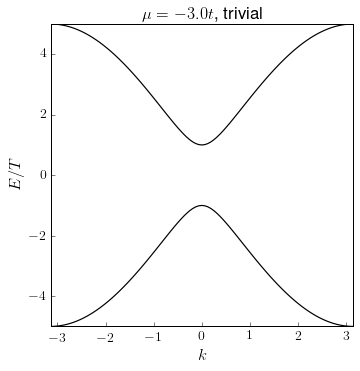
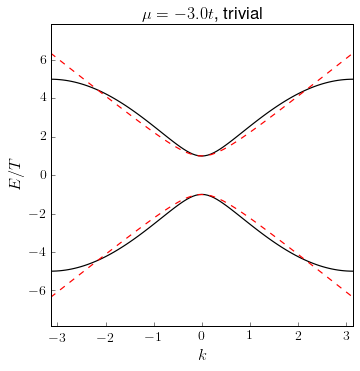
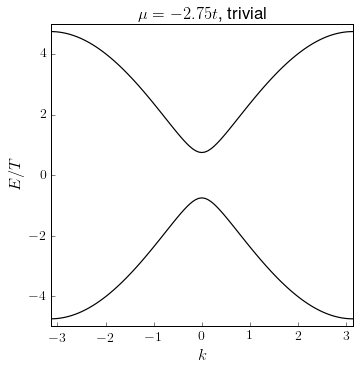
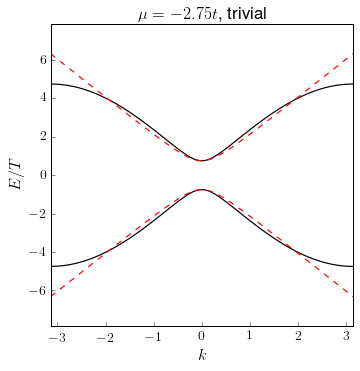
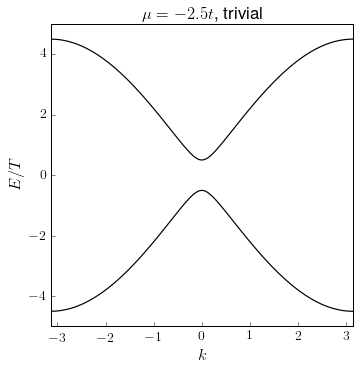
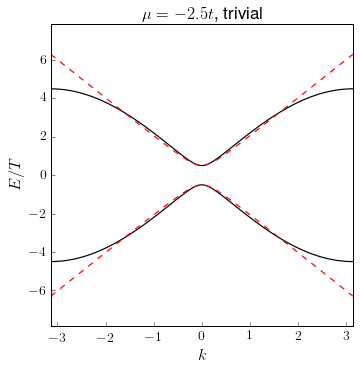
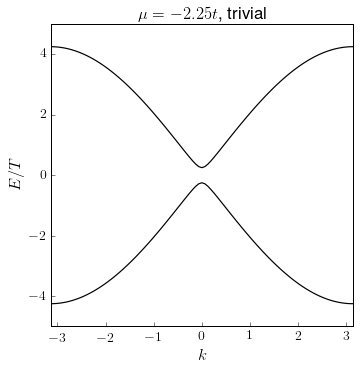
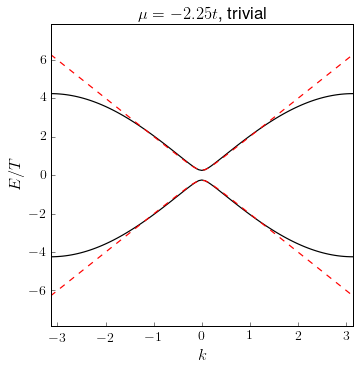
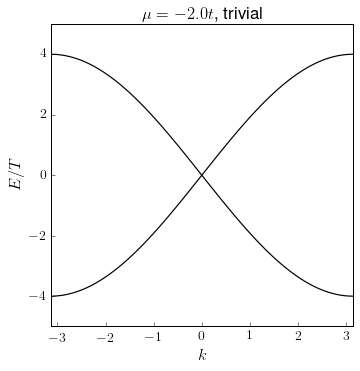
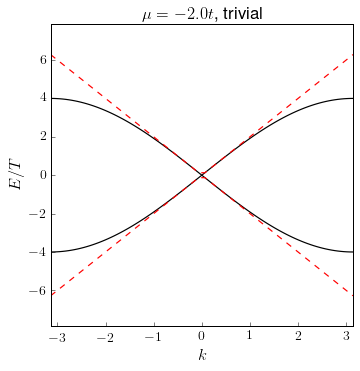
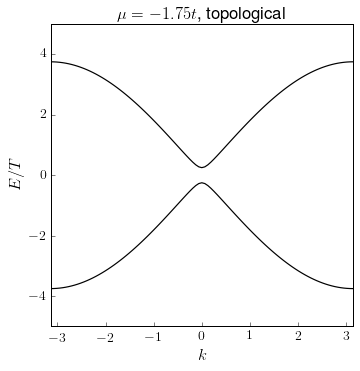
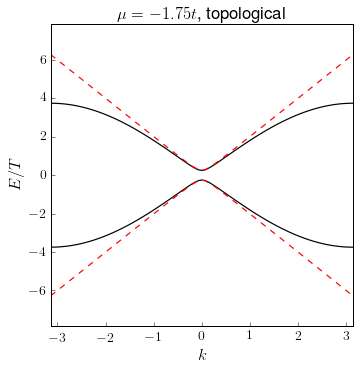
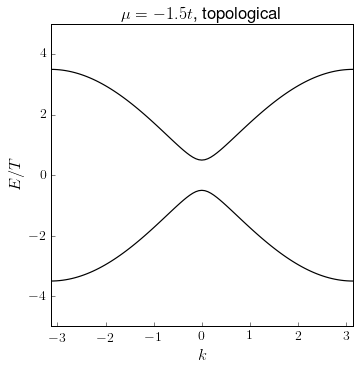
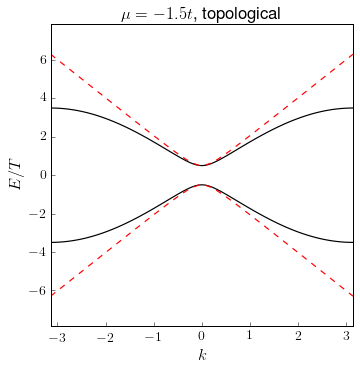
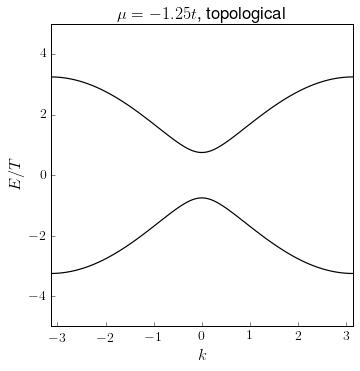
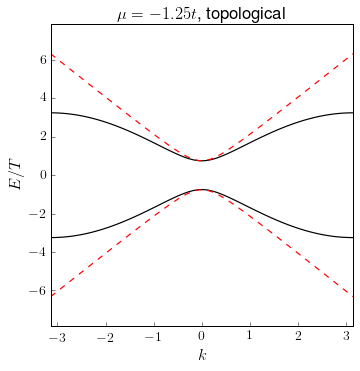
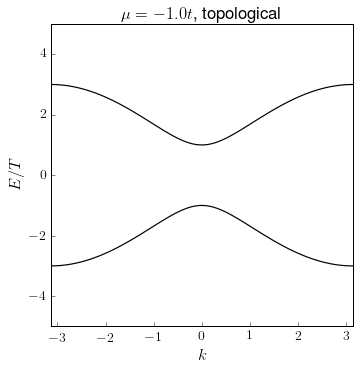
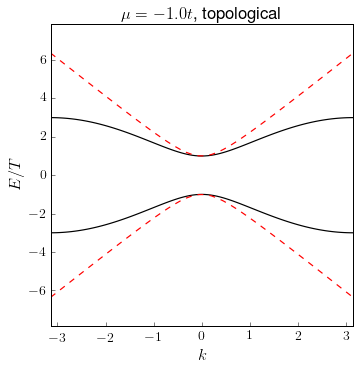
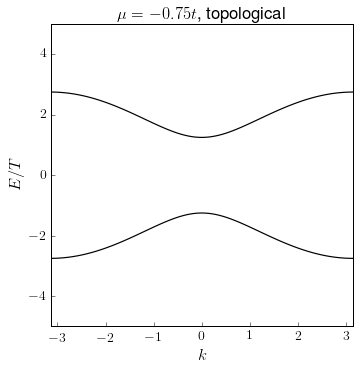
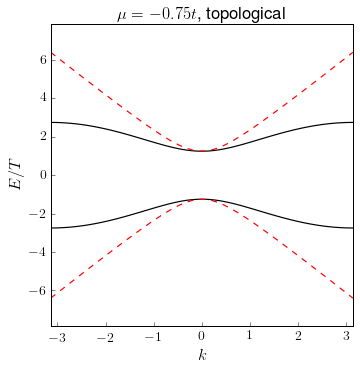
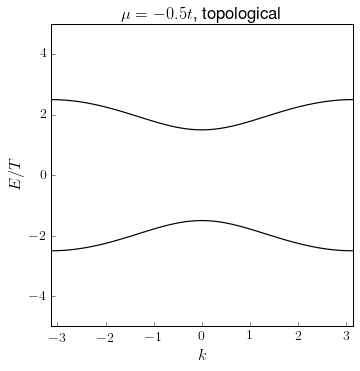
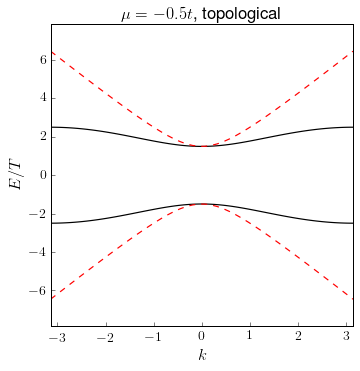
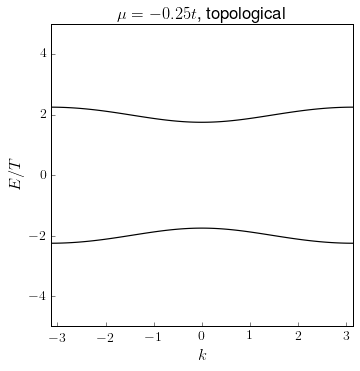
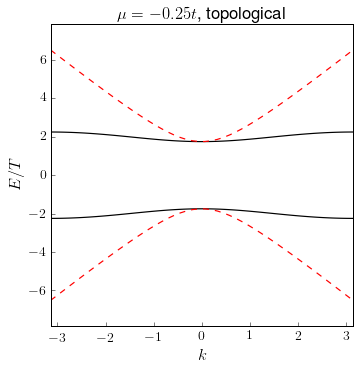
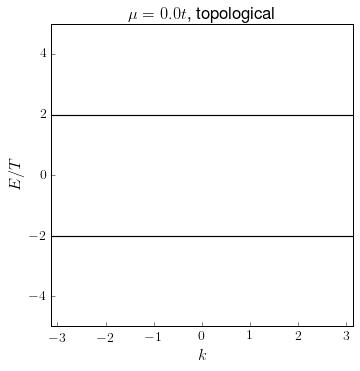
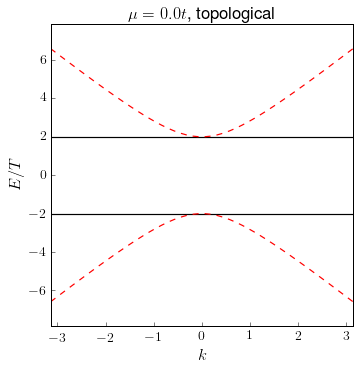
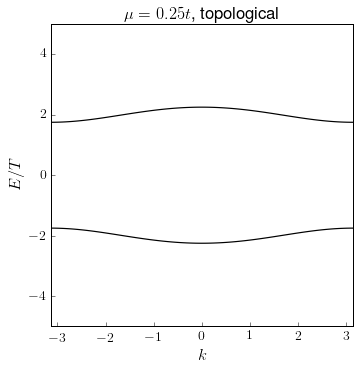
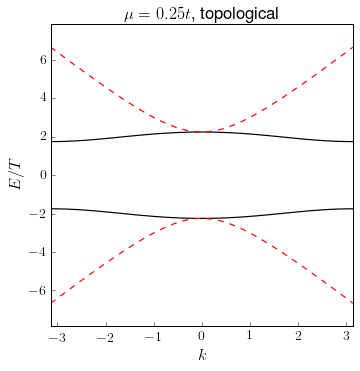
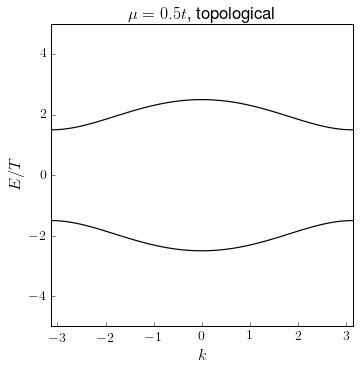
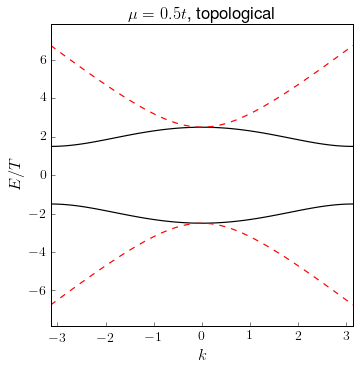
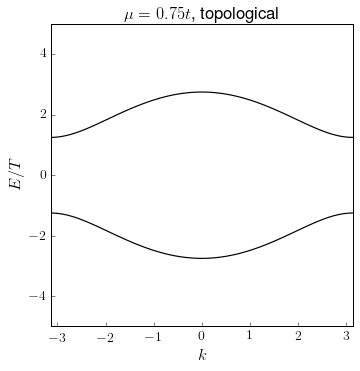
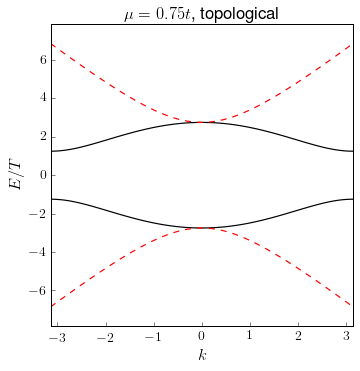
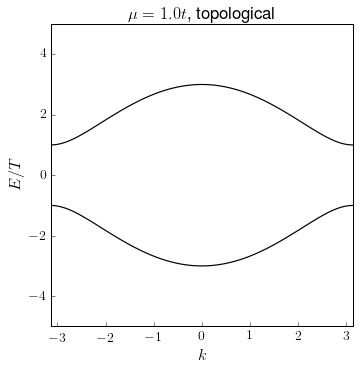
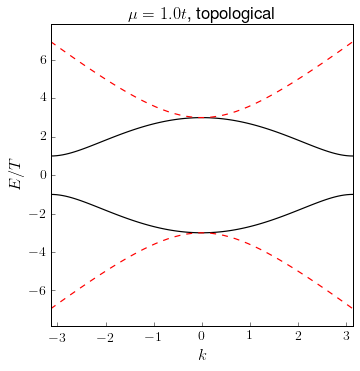
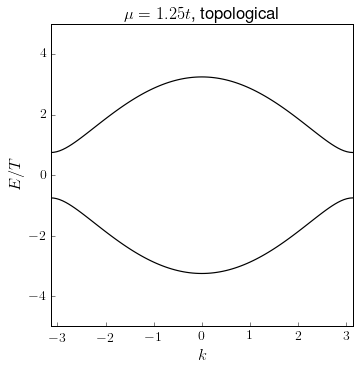
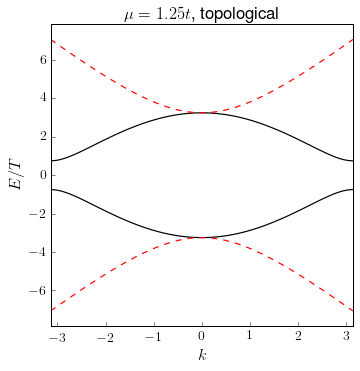
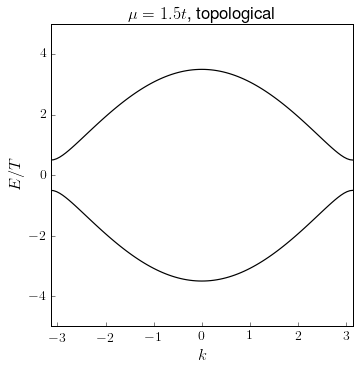
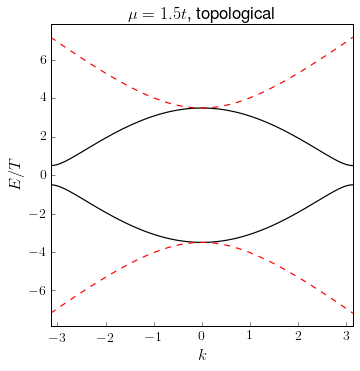
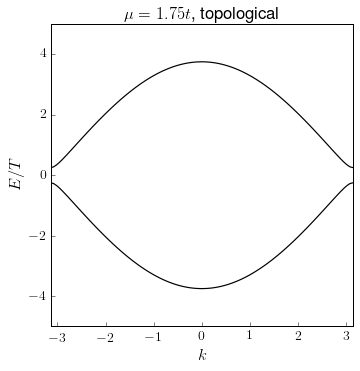
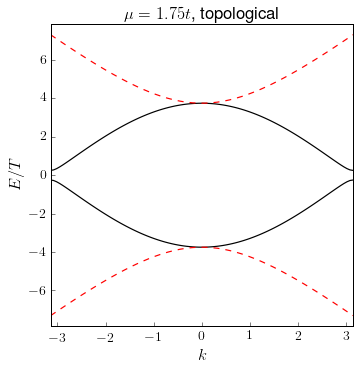
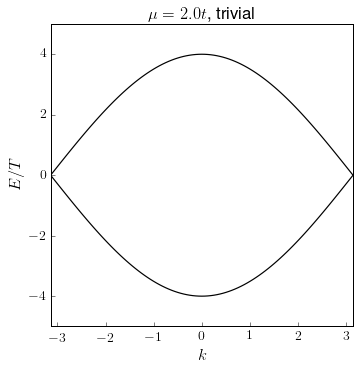
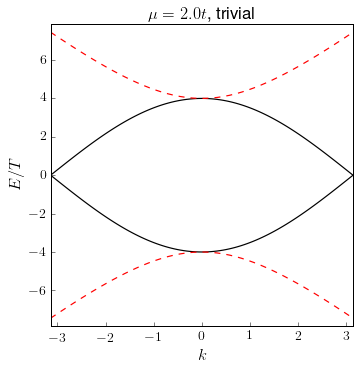
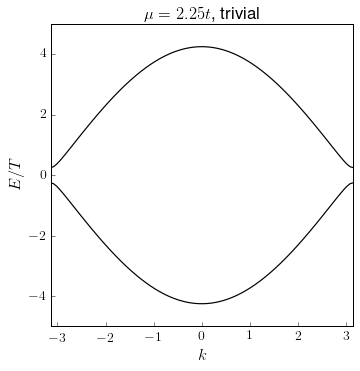
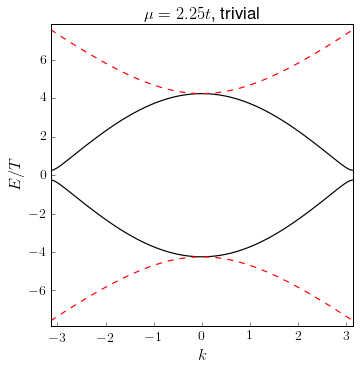
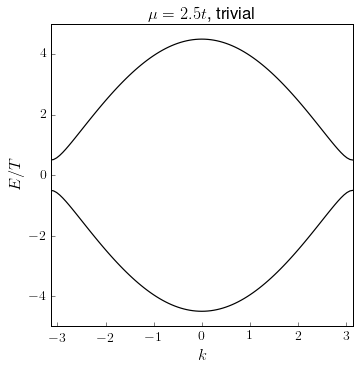
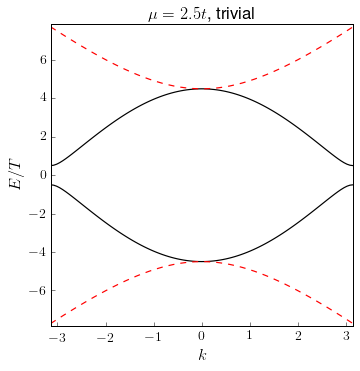
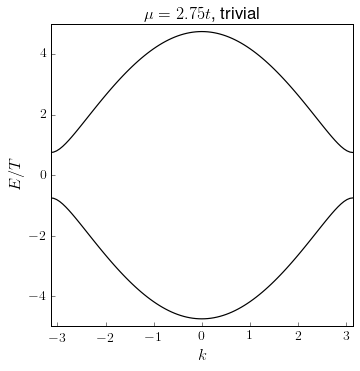
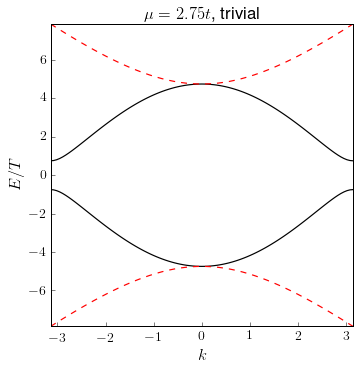

In [5]:
mus = np.arange(-3, 3, 0.25)

plots = {(mu, Dirac_cone): bandstructure(mu, Dirac_cone=Dirac_cone) 
         for mu in mus 
         for Dirac_cone in ["Show", "Hide"]}

holoviews.HoloMap(plots, kdims=[dims.mu_t, "Dirac cone"])

You can see that the energy spectrum is gapped at all $k$ for $\mu=0$. This is natural: Since our chain does not have boundaries anymore, the energy spectrum does not contain the zero energy Majorana modes which we found in the previous subsection at $\mu=0$. However, you can see very clearly the bulk gap closing which occurs at the points $\mu=2t$ and $\mu=-2t$. Indeed, for these values of $\mu$ the two bands at negative and positive energy touch at $E=0$, for $k=\pi$ and $k=0$ respectively.

At first sight, the band structure looks quite similar on both sides of the bulk gap closings. Just from the above plot, it is not clear that the bulk gap closings separate two distinct phases of the model. Nevertheless, we will see that it is possible to rigorously come to this conclusion by studying the properties of $H(k)$ in more detail. But in the meantime, we will start by understanding better what happens close to the transition, by writing down a simple effective model from which we will be able to deduce a lot of information.

## Study of the bulk transition with an effective Dirac model

Let's look at the gapless points more in detail. We focus on the gap closing at $\mu=-2t$, which happens at $k=0$. Close to this point where the two bands touch, we can make a linear expansion of the Hamiltonian $H(k)$,

$$H(k) \simeq m \tau_z + 2\Delta\,k\,\tau_y\,,$$

with $m=-\mu-2t$. We can see that $H(k)$ becomes a **Dirac Hamiltonian** - note that condensed matter physicists use this term quite loosely to refer to any Hamiltonian which is linear in the momentum operator. You can easily check that this Hamiltonian gives an energy spectrum $E(k) = \pm\sqrt{m^2 + 4\Delta^2k^2}$, and by returning to the plot above you can indeed verify that this is a very good approximation of the exact band structure around $\mu=-2t$.

The ''mass'' $m$ appearing in this Dirac Hamiltonian is a very important parameter to describe what is happening. Its magnitude is equal to the energy gap $\left|\mu+2t\right|$ in the band structure close to the gap closing. Its sign reminds us of the two original phases which we encountered in the previous part of the lecture:

* $m<0$ for $\mu>-2t$, which corresponds to the **topological** phase, the one with Majorana modes in the open chain.
* $m>0$ for $\mu<-2t$, which corresponds to the **trivial** phase, the one without Majorana modes in the open chain.

Previously, we had identified the point $\mu=-2t$ as a phase transition between two phases with or without zero energy edge modes. By looking at the bulk Hamiltonian, the same point $\mu=-2t$ appears as a point where the bulk gap closes and *changes sign*.

When $m=0$, the Hamiltonian has two eigenstates with energy $E=\pm 2\Delta k$. These states are the eigenstates of $\tau_y$, hence they are equal weight superpositions of electron and holes. They are in fact Majorana modes, that are left-moving on the branch $E = -2\Delta k$ and right-moving on $E = 2\Delta k$. Now they are free to propagate in the chain since there is no bulk gap anymore. In our simple model, the speed of these modes is given by $v=2\Delta$.

## Majorana modes appearing at a domain wall between different phases

Let us consider the following question: What happens if the mass parameter $m(x)$ varies continuously *in space*, and changes sign at a certain point?

To answer the question, let's write down the Dirac Hamiltonian above in real space. Then we have

$$H = -v\,\tau_y\,i\partial_x + m(x)\, \tau_z.$$

As anticipated, the mass is now a function of position, $m(x)$, with the property that $m(x)\to \pm m$ for $x\to\pm\infty$ and $m(x=0)=0$. The point $x=0$ is a *domain wall*, the border between two regions of space with opposite sign of the mass.

We already know that when $m=0$, the Hamiltonian above has a zero energy Majorana mode as a solution. Let us look at it in more detail. We need to solve the equation $H\Psi=0$, which can be rewritten as

$$\partial_x\Psi(x) = (1/v)\,m(x)\,\tau_x\,\Psi(x).$$

Only a single Pauli matrix $\tau_x$ appears in this equation, which is therefore quite easy to solve. The solutions have the form

$$\Psi(x) = \exp\,\left(\tau_x\int_0^x \frac{m(x')}{v}\, dx'\right) \Psi(0).$$

Two linearly independent solutions are given by the eigenstates of $\tau_x$:

$$\Psi(x) = \exp\,\left(\pm\int_0^x \frac{m(x')}{v}\, dx'\right) \begin{pmatrix} 1 \\ \pm 1 \end{pmatrix}\,.$$

Only one of the two is normalizable, thanks to the fact that $m(x)$ changes sign at $x=0$. In this way we obtain a wave function localized at $x=0$, with two exponential tails on the sides. This solution is our Majorana mode which, in this case, is a bound state localized at the domain wall. Note that no zero-energy solution would exist if $m(x)$ did not change sign. In this case $\Psi(x)$ would not be normalizable at either side of the domain wall.

Physically, we are considering a situation where our system is in the topological phase for $x<0$ and in the trivial phase for $x>0$. Therefore we have just demonstrated that at the interface between these two regions *there must be* a zero energy mode.

![](figures/domain_wall_zero_mode.svg)

To clarify the situation, we can represent the same domain wall with our domino tiles. When you join together two chains of dominoes paired up in a different way, one single unpaired Majorana *must be* left in the middle:

![](figures/domain_wall_with_dominoes.svg)

# Bulk topological invariant and the bulk-edge correspondence

## Bulk topological invariant

Now that we understand the topological transition in more detail, let's go back to the bulk Hamiltonian $H(k)$ of the Kitaev ring and try to generalize our Dirac-equation based criterion for Majorana modes. In our effective Dirac model it was easy to identify a quantity, the mass parameter $m$, whose sign determined whether the system could support unpaired Majorana modes at its ends. Let's now try to turn this effective description into a **bulk topological invariant** which can be computed directly from $H(k)$. We will not attempt to give a rigorous derivation of the bulk invariant - a task which is often difficult even for advanced researchers in the field - but rather to arrive at it in a heuristic manner.

We can start with some important clues. On the one hand, we are studying a Bogoliubov-de Gennes Hamiltonian, and we have already learned that quantum dots with particle-hole symmetry are characterized by a topological invariant, the sign of the Pfaffian, which changes sign at every gap closing. On the other hand, we have just seen that the gap closing in the Kitaev chain model is accompanied by a change of sign of $m$. This suggests to try to link the quantity $m$ to a Pfaffian. How to do so?

In fact, you can think of the full $H_\textrm{BdG}$ as a very large matrix with particle-hole symmetry. It can be put in antisymmetric form and we can compute its Pfaffian. This Pfaffian may change only when an eigenvalue of $H(k)$ passes through zero. Because of particle-hole symmetry, for every eigenvalue $E(k)$ we have one at $-E(-k)$. So if $E(k)$ passes through zero, also its partner does. Furthermore, the spectrum has to be periodic in the Brillouin zone, which means that gap closings at finite momentum always come in pairs, and cannot change the Pfaffian. There are only two points which make exception: $k=0$ and $k=\pi$, which are mapped onto themselves by particle-hole symmetry. In fact, for these points we have:

$$ \tau_x H^*(0)\tau_x=-H(0),$$
$$ \tau_x H^*(\pi)\tau_x=-H(\pi).$$

So $H(0)$ and $H(\pi)$ can always be put individually in antisymmetric form, and we can always compute their Pfaffian. Also, note that these are precisely the points in momentum space where the gap closes: at $k=0$ for $\mu=-2t$ and at $k=\pi$ for $\mu=2t$. All things considered, we have a strong reason to focus exclusively on $H(0)$ and $H(\pi)$. Following the procedure that we learned in the last chapter, we can therefore put $H(0)$ and $H(\pi)$ in antisymmetric form,

$$\tilde{H}(0) = \frac{1}{2}
\begin{pmatrix} 1 & 1 \\ i & -i \end{pmatrix} 
\begin{pmatrix} -2t-\mu & 0 \\ 0 & 2t+\mu \end{pmatrix}
\begin{pmatrix} 1 & -i \\ 1 & i \end{pmatrix} = -i
\begin{pmatrix} 0 & -2t-\mu \\ 2t+\mu & 0\end{pmatrix},$$
$$\tilde{H}(\pi) = \frac{1}{2}
\begin{pmatrix} 1 & 1 \\ i & -i \end{pmatrix} 
\begin{pmatrix} 2t-\mu & 0 \\ 0 & -2t+\mu \end{pmatrix}
\begin{pmatrix} 1 & -i \\ 1 & i \end{pmatrix} = -i
\begin{pmatrix} 0 & 2t-\mu \\ -2t+\mu & 0\end{pmatrix}.$$

We now easily obtain that

$$\textrm{Pf}[iH(0)]=-2t-\mu,$$
$$\textrm{Pf}[iH(\pi)]=2t-\mu.$$

You see that the Pfaffian of $H(0)$ changes sign at $\mu=-2t$, and the Pfaffian of $H(\pi)$ does so at $\mu=2t$, in perfect agreement with the position of the gap closing in the band structure:

b':HoloMap   [$\\mu/t$]\n   :Overlay\n      .Path.I   :Path   [$k$,$E/T$]\n      .VLine.I  :VLine   [x,y]\n      .VLine.II :VLine   [x,y]'
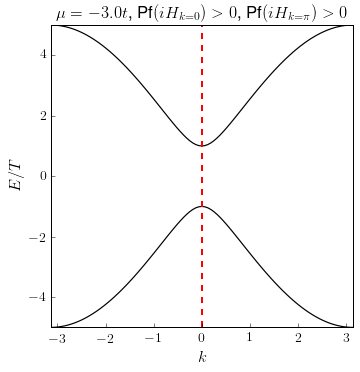
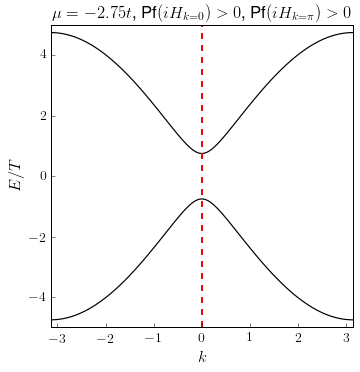
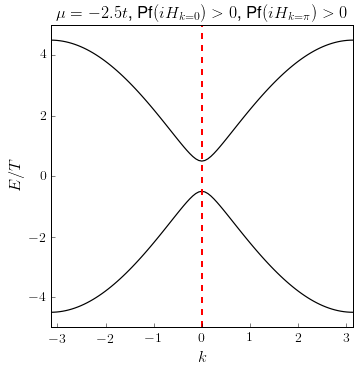
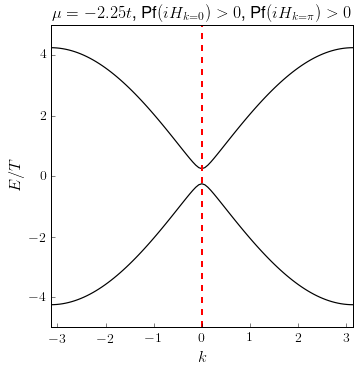
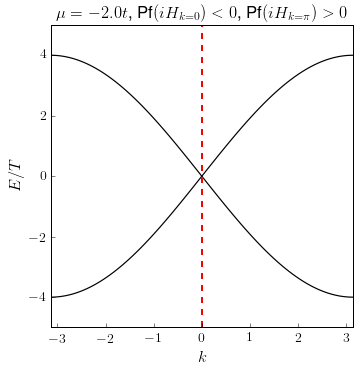
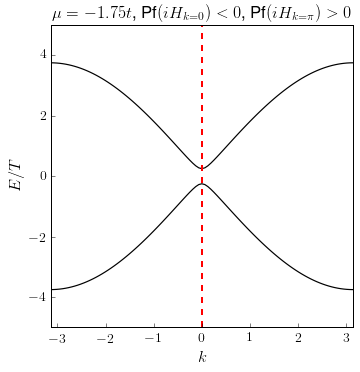
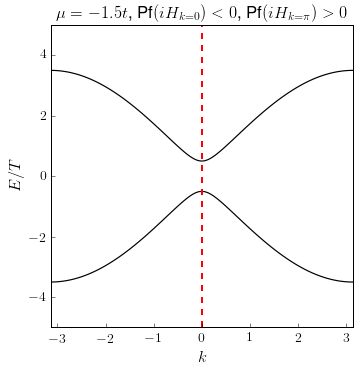
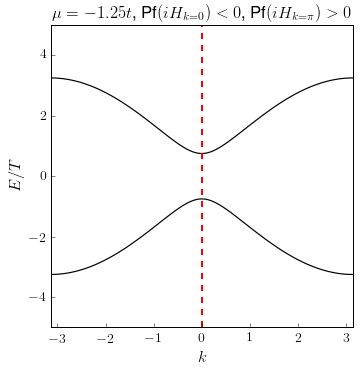
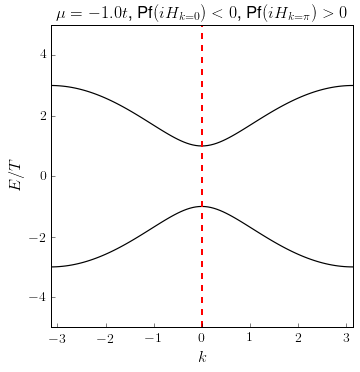
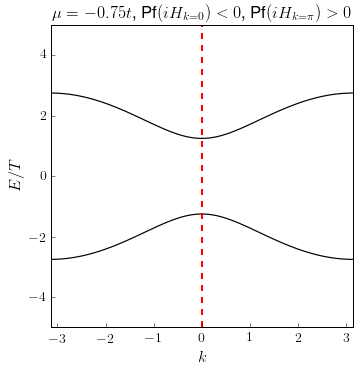
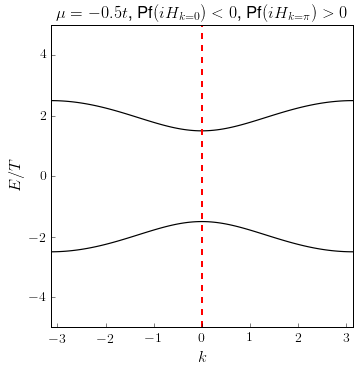
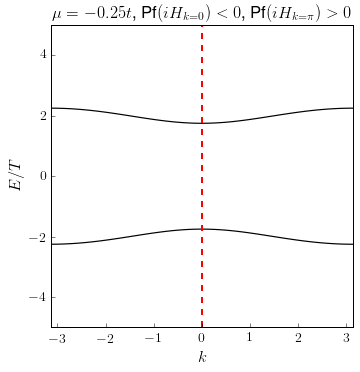
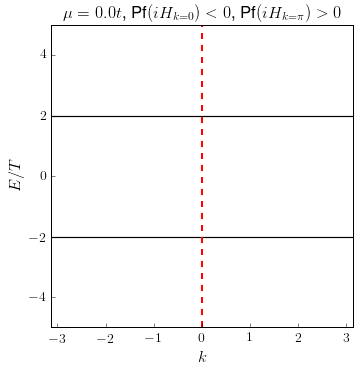
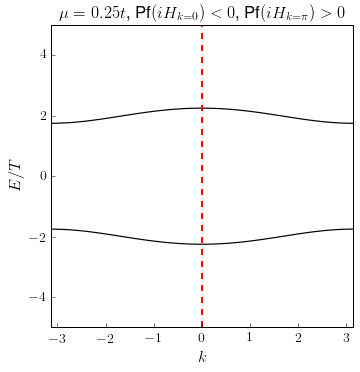
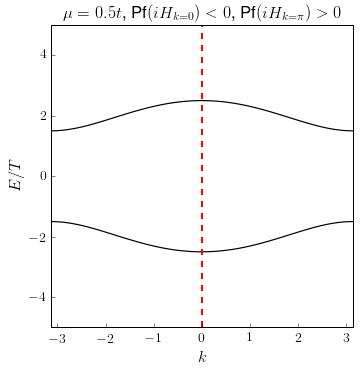
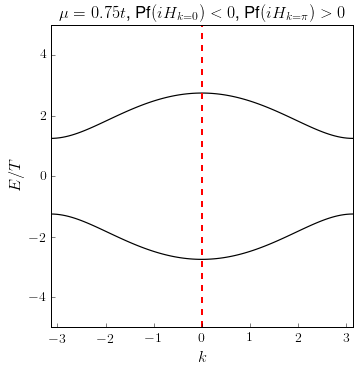
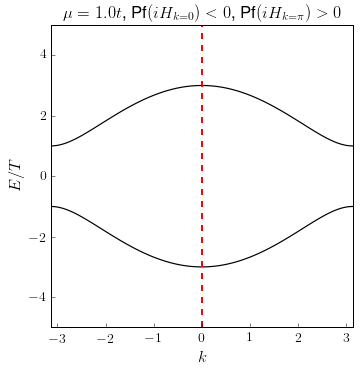
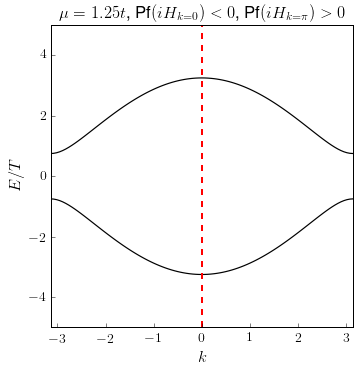
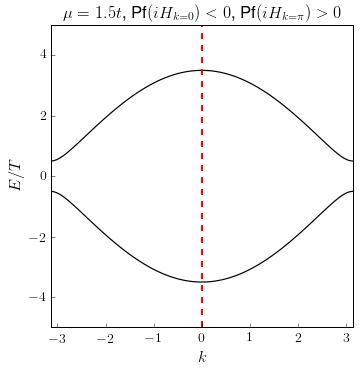
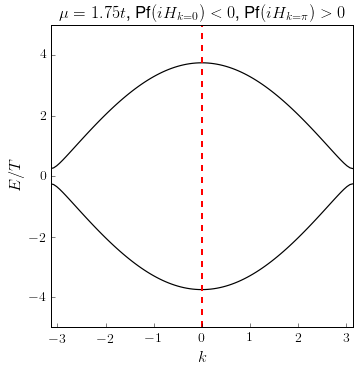
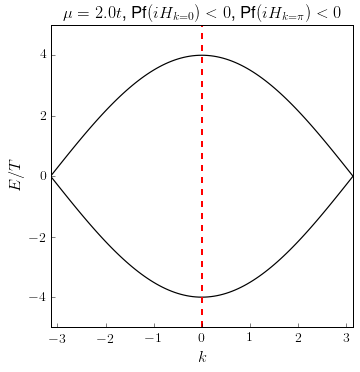
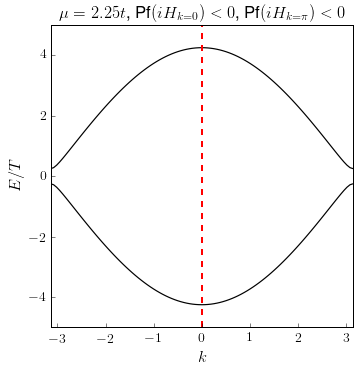
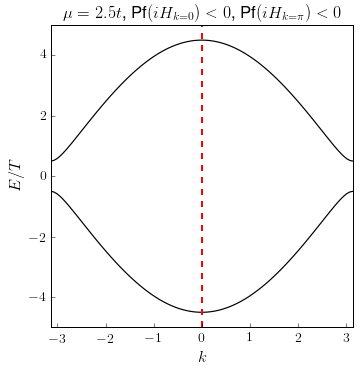
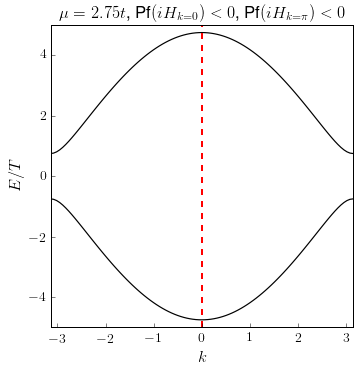

In [6]:
mus = np.arange(-3, 3, 0.25)
holoviews.HoloMap({mu: bandstructure(mu, show_pf=True) for mu in mus}, kdims=[dims.mu_t])

Individually, the two Pfaffians account for one of the two bulk gap closings which can occur in the model. To obtain a single bulk invariant $Q$ we can simply multiply the two! Hence we arrive at the following expression:

$$Q = \textrm{sign}\left(\, \textrm{Pf}[iH(0)]\,\textrm{Pf}[iH(\pi)]\,\right).$$

A value $Q=-1$ means that the bulk is in a topological phase, such that if the wire was cut at a point, two unpaired Majorana modes would appear at the ends of it. On the other hand, a value $Q=+1$ means that the bulk is in the trivial phase. Again, you might think that this expression for $Q$, that we have just cooked up, is only valid for the particular model that we are considering. However, you would be wrong:

> The topological invariant $Q$ cannot change under continuous deformations of the Hamiltonian unless the gap closes.

## Connecting the bulk invariant and the edge modes

At the moment, the bulk topological invariant $Q$ defined above might look just like an abstract mathematical object. We know that $Q=-1$ corresponds to the topological phase, but can we give a more concrete physical meaning to this value? This is the goal of this last part of the lecture.

We have already connected the Pfaffian of a Bogoliubov-de Gennes Hamiltonian to a physical quantity: The ground state fermion parity of the system. Our one-dimensional invariant involves the product of two Pfaffians, $\textrm{Pf}[iH(0)]$ and $\textrm{Pf}[iH(\pi)]$. By taking their product we are somehow *comparing* the fermion parity of the two states of the chain with $k=0$ and $k=\pi$, and we have that $Q=-1$ if and only if the two parities are different.

This means that if we *continuously deform* $H(0)$ into $H(\pi)$ in some way without breaking the particle-hole symmetry, we must encounter a zero-energy level crossing in the energy spectrum, what we called a *fermion parity switch* in the last chapter.

In practice, this can be done in the following way. Let's imagine that we change the boundary conditions of a Kitaev ring with $N$ sites from *periodic* to *antiperiodic* boundary conditions, that is from $\left\langle k | n=0 \right\rangle=\left\langle k | n=N \right\rangle$ to $\left\langle k | n=0 \right\rangle=-\left\langle k | n=N \right\rangle$. This means that the allowed values of momentum shift from $k=2\pi p/N$ to $k = 2\pi p/N + \pi /N$.

Let's now ask what is the difference in ground state fermion parity of the two chains. The value $k=0$ is always present in the chain with periodic boundary conditions, while $k=\pi$ is in the first set if $N$ is even and in the second set if $N$ is odd. This means that in either case, the difference in the ground state fermion parities between the chains with periodic and antiperiodic boundary conditions is equal to $Q$!

To verify this statement, we will now *physically change the boundary condition in real space*. For simplicity, we will do so for a Kitaev ring with $\Delta=t$. You will remember that, in the Majorana basis, this corresponds to the limit where neighboring Majoranas from different sites are coupled by hopping of strength $t$.

To go from periodic to antiperiodic boundary condition, we can change the hopping on the last bond of the ring (the one connecting sites $n=N-1$ and $n=0$) from $t$ to $-t$. This can easily be done continuously and without breaking particle-hole symmetry, for instance by setting the last hopping to be equal to $t\,(1-2\lambda)$ and varying $\lambda$ in the interval $[0,1]$, as shown in this picture:

![](figures/majorana_ring.svg)

You can check that the Bogoliubov-de Gennes Hamiltonian of this closed ring satisfies particle-hole symmetry at every value of $\lambda$. Let's now look at the energy spectrum $E(\lambda)$ of the system as we vary $\mu$ from $0$ to $4t$, passing once again through the gap closing at $\mu=2t$.

b':HoloMap   [$\\mu/t$]\n   :Path   [$\\lambda$,$E/t$]'
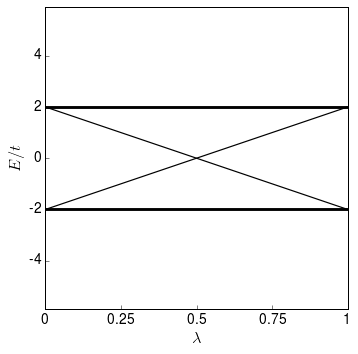
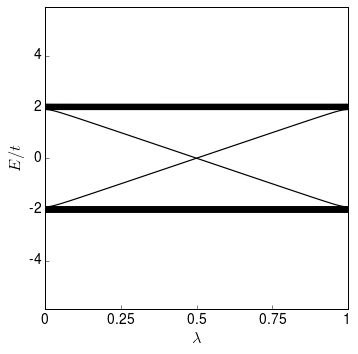
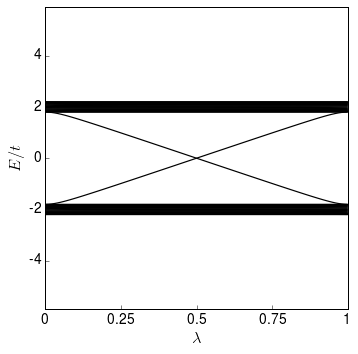
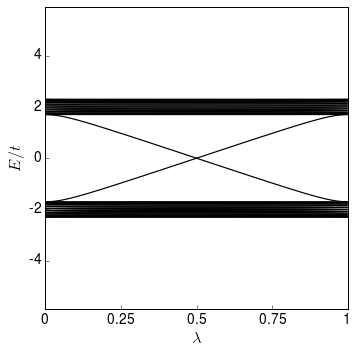
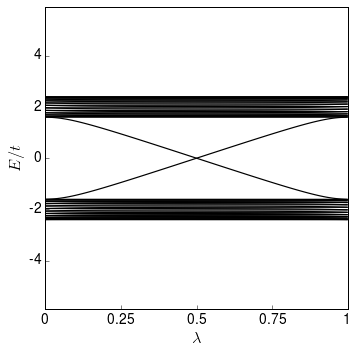
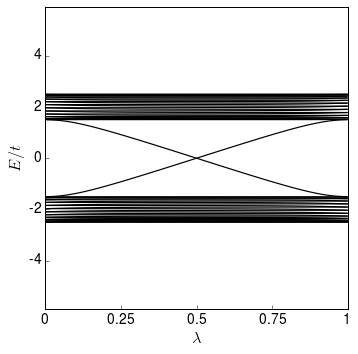
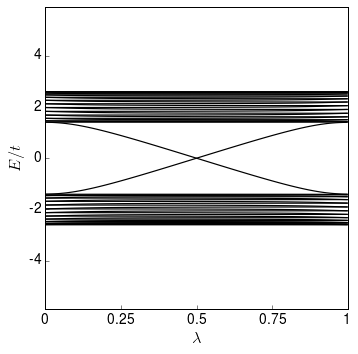
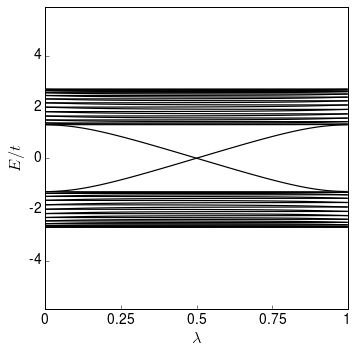
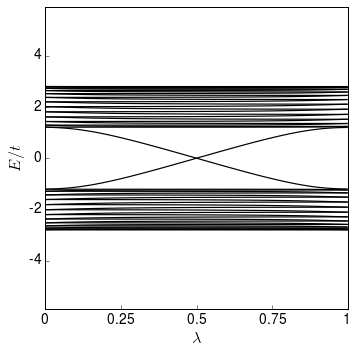
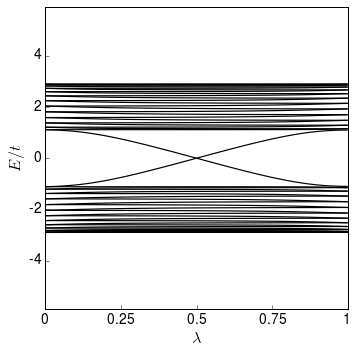
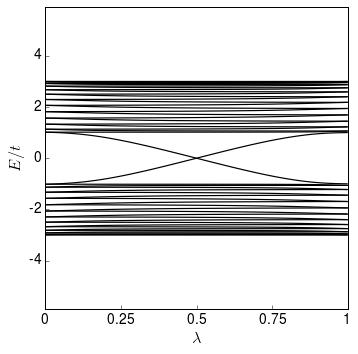
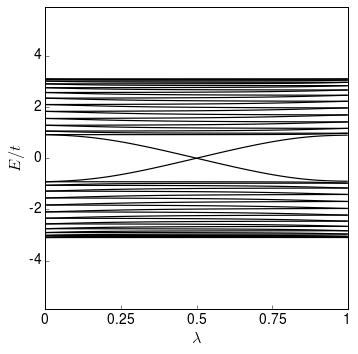
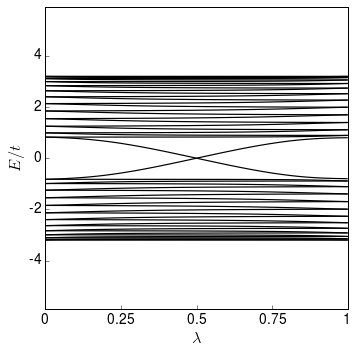
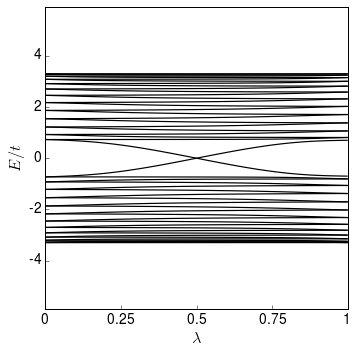
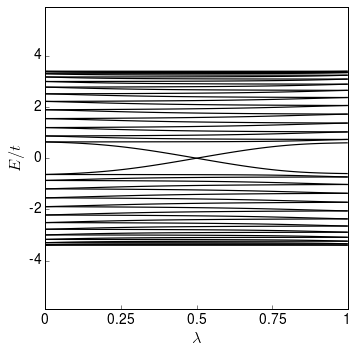
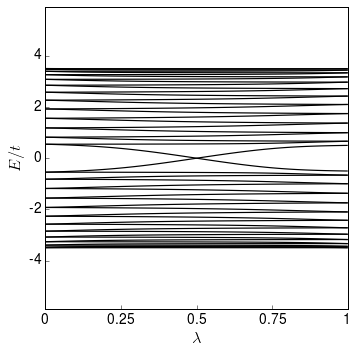
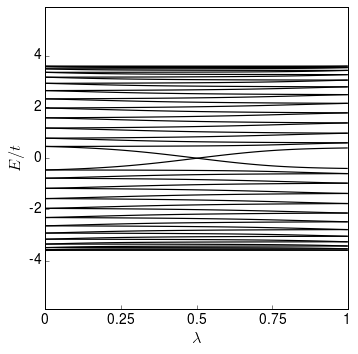
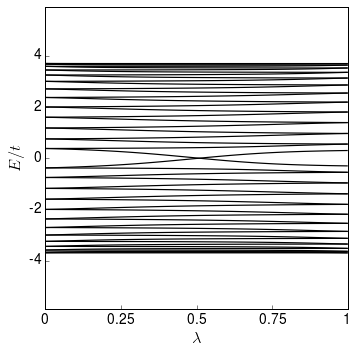
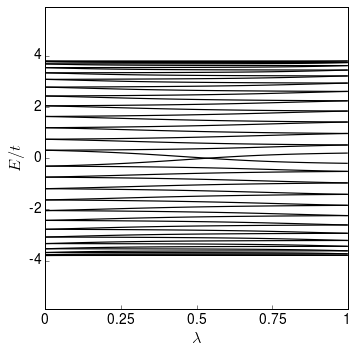
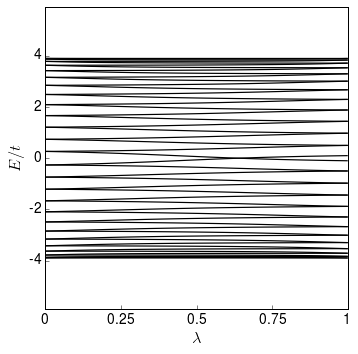
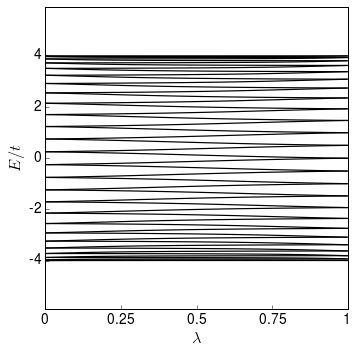
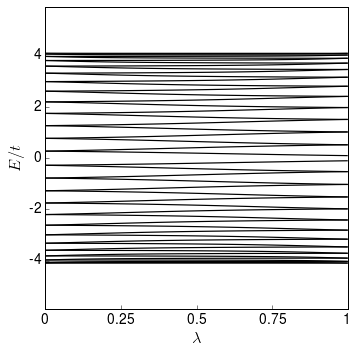
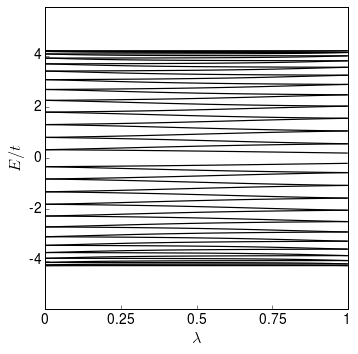
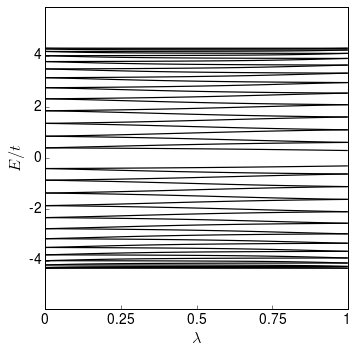
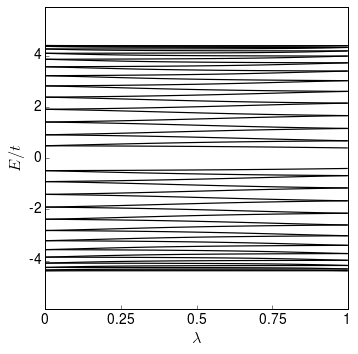
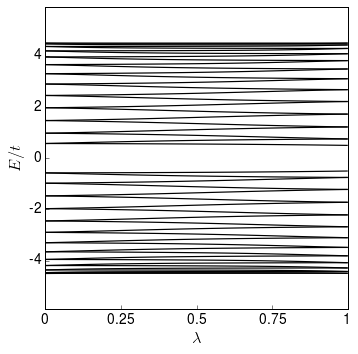
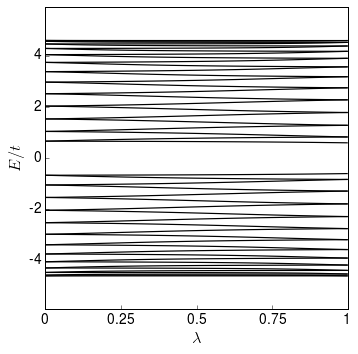
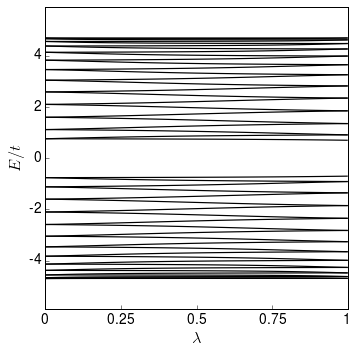
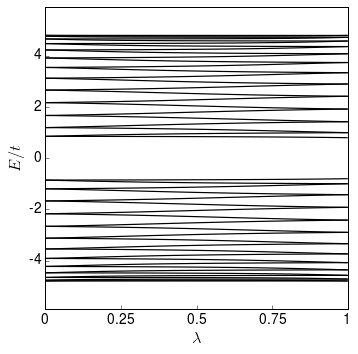
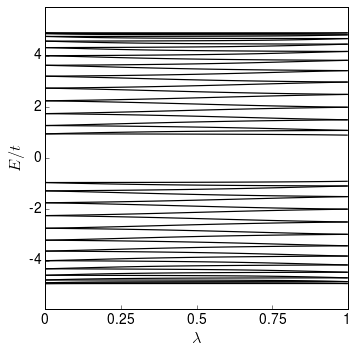
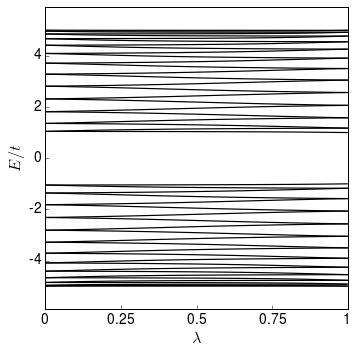
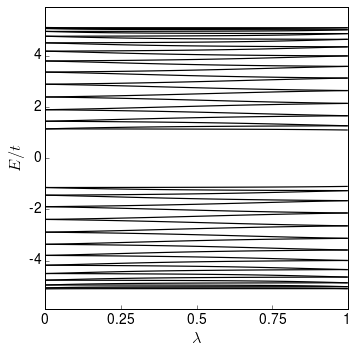
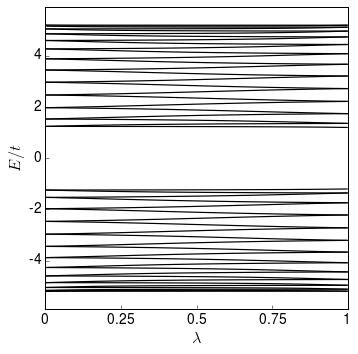
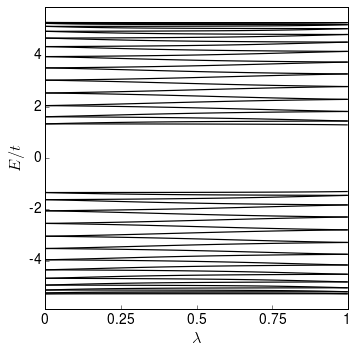
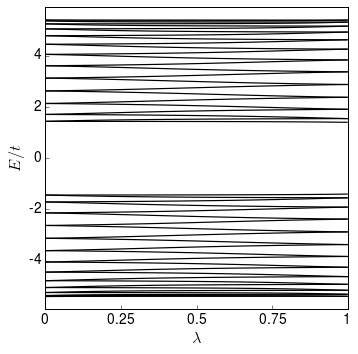
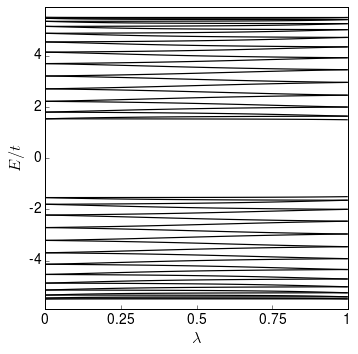
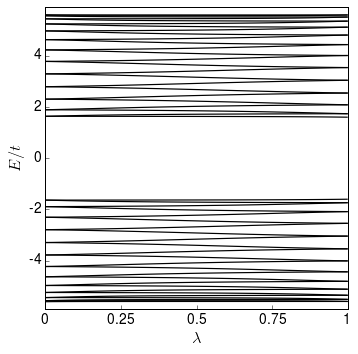
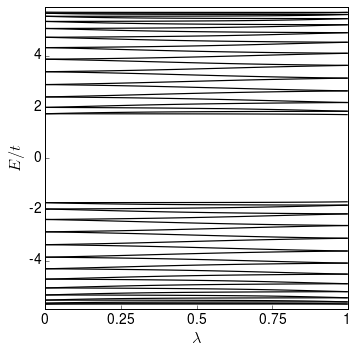
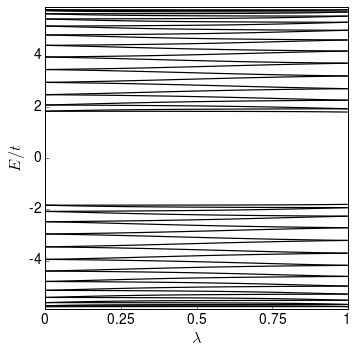
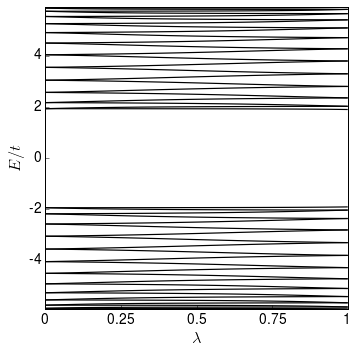

In [7]:
sys = kitaev_chain(L=25, periodic=True)

p = SimpleNamespace(t=1, delta=1, lambda_=np.linspace(0.0, 1.0, 101), mu=None)

kwargs = {'xticks': np.linspace(0, 1, 5), 
          'yticks': np.linspace(-4, 4, 5), 
          'xdim': dims.lambda_, 
          'ydim': dims.E_t}

mus = np.arange(0, 4, 0.1)
holoviews.HoloMap({p.mu: spectrum(sys, p, **kwargs) for p.mu in mus}, kdims=[dims.mu_t])

You can see that for $\mu<2t$, the energy spectrum shows a zero-energy level crossing at $\lambda=1/2$. The fermion parity of the system is therefore different at $\lambda=0$ and $\lambda=1$. When $\lambda=1/2$ the hopping on the last bond is equal to zero. We have introduced a “cut” to the system, such that our closed Kitaev ring is effectively transformed to an open Kitaev chain. Because we are in the topological phase, this open Kitaev chain has two zero-energy unpaired Majorana modes!

On the other hand, when $\mu>2 t$ no zero-energy level crossing is present. The ground state fermion parity is the same at $\lambda=0$ and $\lambda=1$. In this case, when we cut the system at $\lambda=1/2$, we find no unpaired Majorana modes, consistent with our knowledge of the behavior of the open chain in the trivial phase.

We have therefore learned the essence of the bulk-boundary correspondence: A non-trivial value $Q=-1$ of the bulk invariant for the closed chain implies the existence of unpaired Majorana modes for the open chain. Also, we have been able to connect the value of the bulk invariant to a measurable quantity, in this case the ground state fermion parity of the closed chain.

In [8]:
question = ("What will happen if we take a 100 site Kitaev chain in the topological phase " 
            "and change the potential mu to a very large negative value for the last 50 sites?")
answers = ["The topological gap at the last 50 sites closes and reopens as $\mu$ changes from $0$ to $-\infty$.",
           "The Majoranas get destroyed by the drastic change of chemical potential $\mu_j$.",
           "One of the Majoranas moves from being the end of the system to the middle."]
MoocCheckboxesAssessment(question, answers, correct_answers=[0, 2])

MoocCheckboxesAssessment(**{'correct_answers': [0, 2], 'max_attempts': 2, 'answers': ['The topological gap at the last 50 sites closes and reopens as $\\mu$ changes from $0$ to $-\\infty$.', 'The Majoranas get destroyed by the drastic change of chemical potential $\\mu_j$.', 'One of the Majoranas moves from being the end of the system to the middle.'], 'display_name': 'Question', 'question': 'What will happen if we take a 100 site Kitaev chain in the topological phase and change the potential mu to a very large negative value for the last 50 sites?'})

# Three approaches to analysing topological systems

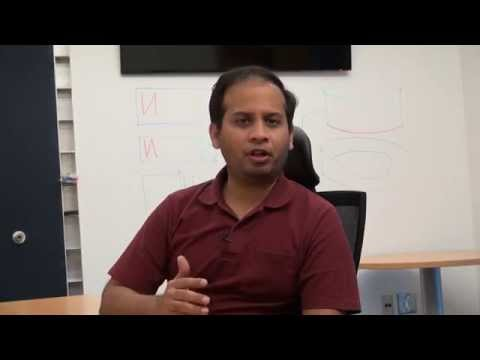

In [9]:
MoocVideo("wiHPQlEha6g", src_location='1.2-summary')

In [10]:
MoocDiscussion('Questions', 'Bulk-edge correspondence in the Kitaev chain')

MoocDiscussion(**{'discussion_id': 'ec783e7c7ccc36284d4393a4722d6cf2', 'display_name': 'Bulk-edge correspondence in the Kitaev chain', 'discussion_target': 'Bulk-edge correspondence in the Kitaev chain', 'discussion_category': 'Questions'})